## 1. 라이브러리 및 데이터

In [1]:
# 필수 라이브러리리
import pandas as pd
import numpy as np
from scipy import stats

# 랜덤시드 고정
import random
import os

# 시각화 및 전처리
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import bisect

# 머신러닝 단일모형 알고리즘
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

# 평가지표
from sklearn.metrics import r2_score,mean_squared_error

# 모델 및 가중치 저장
from tensorflow.python.keras.models import load_model

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(seed=42) # Seed 고정

In [3]:
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 30)
train = pd.read_csv('../DAT/train_pro.csv')
test = pd.read_csv('../DAT/test_pro.csv')

In [4]:
train_dist=train[train['DIST']!=0]
test_dist=test[test['DIST']!=0]

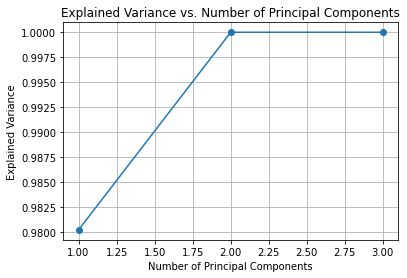

In [8]:
from sklearn.decomposition import PCA

# 주성분 개수 범위 설정
n_components_range = range(1, 4)
explained_variance = []

for n in n_components_range:
    # PCA 모델 생성
    pca = PCA(n_components=n)
    pca.fit(train_dist[['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT']])
    # 누적 설명된 분산 저장
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

plt.plot(n_components_range, explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

In [9]:
# Categorical 컬럼 인코딩
train_dist = train_dist.drop(columns='ATA')
test_dist = test_dist.drop(columns='ATA')

categorical_features = ['ARI_CO','ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train_dist[feature] = le.fit_transform(train_dist[feature].astype(str))
    le_classes_set = set(le.classes_)
    test_dist[feature] = test_dist[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test_dist[feature] = le.transform(test_dist[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.04it/s]


In [10]:
# # PCA 모델 생성 및 차원 축소
# pca = PCA(n_components=1)  # 주성분 개수를 2로 설정
# train_dist['SHIP_ PHYSICAL'] = pca.fit_transform(train_dist[['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT']])
# test_dist['SHIP_ PHYSICAL'] = pca.transform(test_dist[['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT']])

In [11]:
train_dist=train_dist.drop(columns=['BREADTH', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT'])
test_dist=test_dist.drop(columns=['BREADTH', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT'])
# , 'GT'

In [12]:
train_dist=train_dist.drop(columns=['SHIPMANAGER',
                                    'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
                                    'minute', 'BUILT', 'weekday', 'ARI_CO_mean',
                                    'ATA_LT',  'ARI_CO', "ARI_PO_mean", 'day', 'ARI_PO'])
test_dist=test_dist.drop(columns=['SHIPMANAGER',
                                  'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
                                  'minute', 'BUILT', 'weekday', 'ARI_CO_mean',
                                  'ATA_LT',  'ARI_CO', "ARI_PO_mean", 'day', 'ARI_PO'])

In [13]:
po_classify=sorted(train_dist['port_classify'].unique())

In [14]:
import pandas as pd
# 데이터를 저장할 데이터프레임을 담을 리스트를 생성합니다.
x_train_dataframes = []
y_train_dataframes = []
x_test_dataframes = []
x_test_index = []

# 예제를 위해 두 개의 데이터프레임을 생성하고 리스트에 추가합니다.
for po in po_classify:
    x_train_dataframes.append(train_dist[train_dist['port_classify']==po].reset_index(drop=True))
    y_train_dataframes.append(train_dist[train_dist['port_classify']==po]['CI_HOUR'].reset_index(drop=True))
    
    x_test_index.append(test_dist[test_dist['port_classify']==po].index) 
    x_test_dataframes.append(test_dist[test_dist['port_classify']==po].reset_index(drop=True))

In [15]:
for i in range(0, len(x_train_dataframes)):
    x_train_dataframes[i]=x_train_dataframes[i].drop(columns=['port_classify', 'CI_HOUR'])
    x_test_dataframes[i]=x_test_dataframes[i].drop(columns=['port_classify'])

In [16]:
len(x_train_dataframes)

43

In [17]:
x_train_dataframes[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2598 entries, 0 to 2597
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SHIP_TYPE_CATEGORY  2598 non-null   int32  
 1   DIST                2598 non-null   float64
 2   ID                  2598 non-null   int32  
 3   GT                  2598 non-null   int64  
 4   FLAG                2598 non-null   int32  
 5   PORT_SIZE           2598 non-null   float64
 6   year                2598 non-null   int64  
 7   month               2598 non-null   int64  
 8   hour                2598 non-null   int64  
 9   GT/Port_Size        2598 non-null   float64
dtypes: float64(3), int32(3), int64(4)
memory usage: 172.6 KB


In [18]:
x_train_dataframes[38]

,SHIP_TYPE_CATEGORY,DIST,ID,GT,FLAG,PORT_SIZE,year,month,hour,GT/Port_Size
0,0,26.879058,6124,38900,69,0.000117,2018,10,11,3.334133e+08
1,0,14.872415,5045,43000,69,0.000016,2021,12,9,2.621951e+09
2,0,8.066394,4372,43000,83,0.000058,2021,6,13,7.465278e+08
3,3,8.232870,5712,4690,117,0.000068,2022,3,4,6.846715e+07
4,0,4.581591,4001,87400,78,0.000005,2018,9,21,1.908297e+10
...,...,...,...,...,...,...,...,...,...,...
11582,0,20.292355,13603,31200,69,0.000083,2023,2,0,3.759036e+08
11583,1,5.634632,4305,23900,83,0.000010,2021,11,5,2.451282e+09
11584,1,72.053810,15510,5630,80,0.000155,2021,4,20,3.631157e+07
11585,2,8.118171,14601,21000,62,0.000149,2021,1,20,1.411186e+08


In [19]:
from sklearn.preprocessing import RobustScaler

# 로버스트 스케일러 초기화
for i in range(0, len(x_train_dataframes)):
    scaler = RobustScaler()
    x_train_dataframes[i] = pd.DataFrame(scaler.fit_transform(x_train_dataframes[i]), columns=x_train_dataframes[i].columns)
    x_test_dataframes[i] = pd.DataFrame(scaler.transform(x_test_dataframes[i]), columns=x_test_dataframes[i].columns)

### 1) 인공신경망 적합 및 평가

In [20]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
X=x_train_dataframes[0]
y=y_train_dataframes[0]

# 탐색할 패널티 값 범위
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],  # L1 규제 강도
}

# # 릿지 모델에 대한 하이퍼파라미터 탐색
ridge = Ridge()
ridge_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_absolute_error', cv=5)
ridge_search.fit(X, y)

# # 라쏘 모델에 대한 하이퍼파라미터 탐색
lasso = Lasso()
lasso_search = GridSearchCV(lasso, param_grid, scoring='neg_mean_absolute_error', cv=5)
lasso_search.fit(X, y)

# 엘라스틱 넷 모델에 대한 하이퍼파라미터 탐색
# elastic_net = ElasticNet()
# elastic_net_search = GridSearchCV(elastic_net, param_grid, scoring='neg_mean_absolute_error', cv=5)
# elastic_net_search.fit(X, y)

# 최적의 릿지, 라쏘, 엘라스틱 넷 모델
best_ridge = ridge_search.best_estimator_
best_lasso = lasso_search.best_estimator_
# best_elastic_net = elastic_net_search.best_estimator_

print("최적 릿지 모델:", best_ridge)
print("최적 라쏘 모델:", best_lasso)
# print("최적 엘라스틱 넷 모델:", best_elastic_net)

최적 릿지 모델: Ridge(alpha=10)
최적 라쏘 모델: Lasso(alpha=1)


In [23]:
import tensorflow as tf
from keras.regularizers import l1_l2

In [28]:
y_pred_dataframes=[]
for i in range(0, len(x_train_dataframes)):
    ier = tf.keras.initializers.GlorotUniform(seed=42)
    model_swish = tf.keras.Sequential([
        tf.keras.layers.Dense(units=52, activation='swish', input_shape=(10,), kernel_initializer=initializer, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.Dense(units=39, activation='swish', kernel_initializer=initializer, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.Dense(units=26, activation='swish', kernel_initializer=initializer, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.Dense(units=13, activation='swish', kernel_initializer=initializer, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        tf.keras.layers.Dense(units=1, kernel_initializer=initializer, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))
    ])

    model_swish.compile(optimizer=tf.kernitializas.optimizers.Adam(learning_rate=0.001), loss='mae')
    model_swish.fit(x_train_dataframes[i], y_train_dataframes[i], epochs=500, batch_size=32, validation_split=0.2)
    preds = model_swish.predict(x_test_dataframes[i])
    y_pred_dataframes.append(preds)

Epoch 1/500
65/65 [==============================] - 2s 6ms/step - loss: 83.5222 - val_loss: 81.9662
Epoch 2/500
65/65 [==============================] - 0s 3ms/step - loss: 77.7149 - val_loss: 74.3526
Epoch 3/500
65/65 [==============================] - 0s 2ms/step - loss: 66.5614 - val_loss: 62.2242
Epoch 4/500
65/65 [==============================] - 0s 2ms/step - loss: 55.2851 - val_loss: 53.5586
Epoch 5/500
65/65 [==============================] - 0s 2ms/step - loss: 51.8558 - val_loss: 52.2093
Epoch 6/500
65/65 [==============================] - 0s 2ms/step - loss: 51.2119 - val_loss: 51.6517
Epoch 7/500
65/65 [==============================] - 0s 2ms/step - loss: 50.7913 - val_loss: 50.6164
Epoch 8/500
65/65 [==============================] - 0s 2ms/step - loss: 50.6353 - val_loss: 50.5424
Epoch 9/500
65/65 [==============================] - 0s 3ms/step - loss: 50.2863 - val_loss: 50.2733
Epoch 10/500
65/65 [==============================] - 0s 2ms/step - loss: 50.0233 - val_los

Epoch 161/500
65/65 [==============================] - 0s 2ms/step - loss: 46.8575 - val_loss: 47.1825
Epoch 162/500
65/65 [==============================] - 0s 2ms/step - loss: 46.8745 - val_loss: 47.2594
Epoch 163/500
65/65 [==============================] - 0s 3ms/step - loss: 46.8829 - val_loss: 47.1175
Epoch 164/500
65/65 [==============================] - 0s 3ms/step - loss: 46.8307 - val_loss: 47.1278
Epoch 165/500
65/65 [==============================] - 0s 2ms/step - loss: 46.9324 - val_loss: 47.1206
Epoch 166/500
65/65 [==============================] - 0s 2ms/step - loss: 46.9493 - val_loss: 47.1494
Epoch 167/500
65/65 [==============================] - 0s 3ms/step - loss: 46.8677 - val_loss: 47.1136
Epoch 168/500
65/65 [==============================] - 0s 2ms/step - loss: 46.8818 - val_loss: 47.2410
Epoch 169/500
65/65 [==============================] - 0s 3ms/step - loss: 46.9088 - val_loss: 47.1783
Epoch 170/500
65/65 [==============================] - 0s 2ms/step - loss

65/65 [==============================] - 0s 3ms/step - loss: 46.2285 - val_loss: 46.7675
Epoch 320/500
65/65 [==============================] - 0s 3ms/step - loss: 46.2047 - val_loss: 46.6389
Epoch 321/500
65/65 [==============================] - 0s 3ms/step - loss: 46.2260 - val_loss: 46.6807
Epoch 322/500
65/65 [==============================] - 0s 3ms/step - loss: 46.2395 - val_loss: 46.6804
Epoch 323/500
65/65 [==============================] - 0s 3ms/step - loss: 46.2351 - val_loss: 46.6545
Epoch 324/500
65/65 [==============================] - 0s 3ms/step - loss: 46.2082 - val_loss: 46.6243
Epoch 325/500
65/65 [==============================] - 0s 3ms/step - loss: 46.1800 - val_loss: 46.8003
Epoch 326/500
65/65 [==============================] - 0s 3ms/step - loss: 46.2243 - val_loss: 46.6791
Epoch 327/500
65/65 [==============================] - 0s 3ms/step - loss: 46.1804 - val_loss: 46.6576
Epoch 328/500
65/65 [==============================] - 0s 3ms/step - loss: 46.1763 - va

65/65 [==============================] - 0s 2ms/step - loss: 45.9175 - val_loss: 46.6348
Epoch 478/500
65/65 [==============================] - 0s 3ms/step - loss: 45.9275 - val_loss: 46.6663
Epoch 479/500
65/65 [==============================] - 0s 2ms/step - loss: 45.9506 - val_loss: 46.6959
Epoch 480/500
65/65 [==============================] - 0s 3ms/step - loss: 45.9853 - val_loss: 46.6624
Epoch 481/500
65/65 [==============================] - 0s 2ms/step - loss: 45.9936 - val_loss: 46.6889
Epoch 482/500
65/65 [==============================] - 0s 2ms/step - loss: 45.9162 - val_loss: 46.6594
Epoch 483/500
65/65 [==============================] - 0s 3ms/step - loss: 45.9231 - val_loss: 46.6633
Epoch 484/500
65/65 [==============================] - 0s 3ms/step - loss: 45.9398 - val_loss: 46.7196
Epoch 485/500
65/65 [==============================] - 0s 2ms/step - loss: 45.9255 - val_loss: 46.6979
Epoch 486/500
65/65 [==============================] - 0s 3ms/step - loss: 45.9509 - va

Epoch 57/500
90/90 [==============================] - 0s 3ms/step - loss: 62.6334 - val_loss: 61.7846
Epoch 58/500
90/90 [==============================] - 0s 3ms/step - loss: 62.5892 - val_loss: 61.8083
Epoch 59/500
90/90 [==============================] - 0s 2ms/step - loss: 62.5662 - val_loss: 61.7803
Epoch 60/500
90/90 [==============================] - 0s 3ms/step - loss: 62.5715 - val_loss: 61.7213
Epoch 61/500
90/90 [==============================] - 0s 2ms/step - loss: 62.5121 - val_loss: 61.7626
Epoch 62/500
90/90 [==============================] - 0s 3ms/step - loss: 62.5199 - val_loss: 61.8012
Epoch 63/500
90/90 [==============================] - 0s 3ms/step - loss: 62.4521 - val_loss: 61.7192
Epoch 64/500
90/90 [==============================] - 0s 3ms/step - loss: 62.5379 - val_loss: 61.6810
Epoch 65/500
90/90 [==============================] - 0s 2ms/step - loss: 62.4535 - val_loss: 61.6471
Epoch 66/500
90/90 [==============================] - 0s 2ms/step - loss: 62.4406 

Epoch 137/500
90/90 [==============================] - 0s 2ms/step - loss: 61.6667 - val_loss: 60.7932
Epoch 138/500
90/90 [==============================] - 0s 2ms/step - loss: 61.6342 - val_loss: 60.6459
Epoch 139/500
90/90 [==============================] - 0s 2ms/step - loss: 61.6451 - val_loss: 60.7323
Epoch 140/500
90/90 [==============================] - 0s 2ms/step - loss: 61.6222 - val_loss: 60.6236
Epoch 141/500
90/90 [==============================] - 0s 3ms/step - loss: 61.5975 - val_loss: 60.5913
Epoch 142/500
90/90 [==============================] - 0s 2ms/step - loss: 61.6045 - val_loss: 60.6119
Epoch 143/500
90/90 [==============================] - 0s 2ms/step - loss: 61.6061 - val_loss: 60.7989
Epoch 144/500
90/90 [==============================] - 0s 2ms/step - loss: 61.6018 - val_loss: 60.5818
Epoch 145/500
90/90 [==============================] - 0s 2ms/step - loss: 61.5937 - val_loss: 60.4578
Epoch 146/500
90/90 [==============================] - 0s 2ms/step - loss

90/90 [==============================] - 0s 2ms/step - loss: 61.0422 - val_loss: 59.9320
Epoch 296/500
90/90 [==============================] - 0s 2ms/step - loss: 61.0762 - val_loss: 59.9508
Epoch 297/500
90/90 [==============================] - 0s 3ms/step - loss: 61.0564 - val_loss: 59.8660
Epoch 298/500
90/90 [==============================] - 0s 3ms/step - loss: 60.9976 - val_loss: 59.9853
Epoch 299/500
90/90 [==============================] - 0s 2ms/step - loss: 61.0354 - val_loss: 60.1329
Epoch 300/500
90/90 [==============================] - 0s 2ms/step - loss: 61.0303 - val_loss: 59.9579
Epoch 301/500
90/90 [==============================] - 0s 3ms/step - loss: 61.0030 - val_loss: 59.8221
Epoch 302/500
90/90 [==============================] - 0s 3ms/step - loss: 61.0187 - val_loss: 59.8322
Epoch 303/500
90/90 [==============================] - 0s 3ms/step - loss: 61.0076 - val_loss: 60.0484
Epoch 304/500
90/90 [==============================] - 0s 2ms/step - loss: 61.0362 - va

90/90 [==============================] - 0s 2ms/step - loss: 60.8513 - val_loss: 59.6324
Epoch 454/500
90/90 [==============================] - 0s 2ms/step - loss: 60.8190 - val_loss: 59.9122
Epoch 455/500
90/90 [==============================] - 0s 2ms/step - loss: 60.7897 - val_loss: 59.6701
Epoch 456/500
90/90 [==============================] - 0s 2ms/step - loss: 60.8567 - val_loss: 59.6372
Epoch 457/500
90/90 [==============================] - 0s 2ms/step - loss: 60.8259 - val_loss: 59.7138
Epoch 458/500
90/90 [==============================] - 0s 2ms/step - loss: 60.8569 - val_loss: 59.7169
Epoch 459/500
90/90 [==============================] - 0s 2ms/step - loss: 60.7928 - val_loss: 59.8130
Epoch 460/500
90/90 [==============================] - 0s 2ms/step - loss: 60.7909 - val_loss: 59.8468
Epoch 461/500
90/90 [==============================] - 0s 2ms/step - loss: 60.7840 - val_loss: 59.6982
Epoch 462/500
90/90 [==============================] - 0s 2ms/step - loss: 60.8070 - va

Epoch 32/500
282/282 [==============================] - 1s 2ms/step - loss: 62.1236 - val_loss: 60.7512
Epoch 33/500
282/282 [==============================] - 1s 3ms/step - loss: 62.0872 - val_loss: 60.7693
Epoch 34/500
282/282 [==============================] - 1s 3ms/step - loss: 62.1018 - val_loss: 60.6688
Epoch 35/500
282/282 [==============================] - 1s 2ms/step - loss: 62.0844 - val_loss: 60.7302
Epoch 36/500
282/282 [==============================] - 1s 2ms/step - loss: 62.0509 - val_loss: 60.7598
Epoch 37/500
282/282 [==============================] - 1s 2ms/step - loss: 62.0682 - val_loss: 60.7727
Epoch 38/500
282/282 [==============================] - 1s 2ms/step - loss: 62.0665 - val_loss: 60.6896
Epoch 39/500
282/282 [==============================] - 1s 2ms/step - loss: 62.0100 - val_loss: 60.7228
Epoch 40/500
282/282 [==============================] - 0s 2ms/step - loss: 62.0086 - val_loss: 60.6197
Epoch 41/500
282/282 [==============================] - 1s 2ms/s

282/282 [==============================] - 1s 2ms/step - loss: 61.5423 - val_loss: 60.1352
Epoch 189/500
282/282 [==============================] - 1s 2ms/step - loss: 61.5798 - val_loss: 60.0581
Epoch 190/500
282/282 [==============================] - 1s 3ms/step - loss: 61.5651 - val_loss: 60.0245
Epoch 191/500
282/282 [==============================] - 1s 3ms/step - loss: 61.5472 - val_loss: 59.9827
Epoch 192/500
282/282 [==============================] - 1s 3ms/step - loss: 61.5628 - val_loss: 60.0092
Epoch 193/500
282/282 [==============================] - 1s 3ms/step - loss: 61.5554 - val_loss: 59.9642
Epoch 194/500
282/282 [==============================] - 1s 2ms/step - loss: 61.5558 - val_loss: 59.9592
Epoch 195/500
282/282 [==============================] - 1s 2ms/step - loss: 61.5435 - val_loss: 59.9857
Epoch 196/500
282/282 [==============================] - 1s 2ms/step - loss: 61.5618 - val_loss: 59.9820
Epoch 197/500
282/282 [==============================] - 1s 2ms/step 

282/282 [==============================] - 1s 2ms/step - loss: 61.4651 - val_loss: 59.8739
Epoch 345/500
282/282 [==============================] - 1s 2ms/step - loss: 61.4550 - val_loss: 59.9130
Epoch 346/500
282/282 [==============================] - 1s 2ms/step - loss: 61.4481 - val_loss: 59.8859
Epoch 347/500
282/282 [==============================] - 0s 2ms/step - loss: 61.4275 - val_loss: 60.0006
Epoch 348/500
282/282 [==============================] - 1s 2ms/step - loss: 61.4692 - val_loss: 59.9054
Epoch 349/500
282/282 [==============================] - 1s 2ms/step - loss: 61.4559 - val_loss: 59.8587
Epoch 350/500
282/282 [==============================] - 1s 2ms/step - loss: 61.4585 - val_loss: 59.8575
Epoch 351/500
282/282 [==============================] - 1s 2ms/step - loss: 61.4574 - val_loss: 59.8466
Epoch 352/500
282/282 [==============================] - 1s 2ms/step - loss: 61.4489 - val_loss: 59.8614
Epoch 353/500
282/282 [==============================] - 0s 2ms/step 

201/201 [==============================] - 0s 2ms/step
Epoch 1/500
113/113 [==============================] - 2s 5ms/step - loss: 141.9938 - val_loss: 132.9195
Epoch 2/500
113/113 [==============================] - 0s 2ms/step - loss: 120.6025 - val_loss: 100.7277
Epoch 3/500
113/113 [==============================] - 0s 3ms/step - loss: 104.2233 - val_loss: 98.2908
Epoch 4/500
113/113 [==============================] - 0s 2ms/step - loss: 102.7325 - val_loss: 97.6427
Epoch 5/500
113/113 [==============================] - 0s 2ms/step - loss: 102.0121 - val_loss: 97.3857
Epoch 6/500
113/113 [==============================] - 0s 2ms/step - loss: 101.6837 - val_loss: 97.1690
Epoch 7/500
113/113 [==============================] - 0s 2ms/step - loss: 101.4428 - val_loss: 97.0403
Epoch 8/500
113/113 [==============================] - 0s 3ms/step - loss: 101.3595 - val_loss: 96.7641
Epoch 9/500
113/113 [==============================] - 0s 2ms/step - loss: 101.0797 - val_loss: 96.6624
Epoch 1

113/113 [==============================] - 0s 2ms/step - loss: 97.3866 - val_loss: 94.5360
Epoch 157/500
113/113 [==============================] - 0s 2ms/step - loss: 97.3615 - val_loss: 94.4922
Epoch 158/500
113/113 [==============================] - 0s 2ms/step - loss: 97.3643 - val_loss: 94.4460
Epoch 159/500
113/113 [==============================] - 0s 3ms/step - loss: 97.3410 - val_loss: 94.4628
Epoch 160/500
113/113 [==============================] - 0s 2ms/step - loss: 97.3385 - val_loss: 94.4892
Epoch 161/500
113/113 [==============================] - 0s 3ms/step - loss: 97.3981 - val_loss: 94.5465
Epoch 162/500
113/113 [==============================] - 0s 2ms/step - loss: 97.3311 - val_loss: 94.7323
Epoch 163/500
113/113 [==============================] - 0s 3ms/step - loss: 97.3574 - val_loss: 94.5698
Epoch 164/500
113/113 [==============================] - 0s 3ms/step - loss: 97.3438 - val_loss: 94.5517
Epoch 165/500
113/113 [==============================] - 0s 3ms/step 

113/113 [==============================] - 0s 2ms/step - loss: 96.7358 - val_loss: 94.2606
Epoch 313/500
113/113 [==============================] - 0s 3ms/step - loss: 96.7446 - val_loss: 94.2243
Epoch 314/500
113/113 [==============================] - 0s 2ms/step - loss: 96.7345 - val_loss: 94.2323
Epoch 315/500
113/113 [==============================] - 0s 2ms/step - loss: 96.7449 - val_loss: 94.1983
Epoch 316/500
113/113 [==============================] - 0s 3ms/step - loss: 96.7229 - val_loss: 94.1681
Epoch 317/500
113/113 [==============================] - 0s 2ms/step - loss: 96.7484 - val_loss: 94.1925
Epoch 318/500
113/113 [==============================] - 0s 2ms/step - loss: 96.7543 - val_loss: 94.2283
Epoch 319/500
113/113 [==============================] - 0s 2ms/step - loss: 96.7330 - val_loss: 94.2528
Epoch 320/500
113/113 [==============================] - 0s 2ms/step - loss: 96.7367 - val_loss: 94.2764
Epoch 321/500
113/113 [==============================] - 0s 2ms/step 

113/113 [==============================] - 0s 3ms/step - loss: 96.3874 - val_loss: 94.0063
Epoch 469/500
113/113 [==============================] - 0s 3ms/step - loss: 96.3880 - val_loss: 94.0259
Epoch 470/500
113/113 [==============================] - 0s 3ms/step - loss: 96.3697 - val_loss: 94.0367
Epoch 471/500
113/113 [==============================] - 0s 2ms/step - loss: 96.3494 - val_loss: 94.0757
Epoch 472/500
113/113 [==============================] - 0s 2ms/step - loss: 96.3975 - val_loss: 94.0946
Epoch 473/500
113/113 [==============================] - 0s 3ms/step - loss: 96.3951 - val_loss: 94.0835
Epoch 474/500
113/113 [==============================] - 0s 4ms/step - loss: 96.3576 - val_loss: 94.0093
Epoch 475/500
113/113 [==============================] - 0s 3ms/step - loss: 96.3669 - val_loss: 94.0409
Epoch 476/500
113/113 [==============================] - 0s 3ms/step - loss: 96.3594 - val_loss: 94.0344
Epoch 477/500
113/113 [==============================] - 0s 3ms/step 

85/85 [==============================] - 0s 2ms/step - loss: 155.9153 - val_loss: 160.0279
Epoch 125/500
85/85 [==============================] - 0s 2ms/step - loss: 155.9646 - val_loss: 160.2492
Epoch 126/500
85/85 [==============================] - 0s 2ms/step - loss: 156.1212 - val_loss: 159.6357
Epoch 127/500
85/85 [==============================] - 0s 2ms/step - loss: 155.9723 - val_loss: 159.6397
Epoch 128/500
85/85 [==============================] - 0s 2ms/step - loss: 155.9063 - val_loss: 160.3029
Epoch 129/500
85/85 [==============================] - 0s 3ms/step - loss: 155.8518 - val_loss: 160.1555
Epoch 130/500
85/85 [==============================] - 0s 3ms/step - loss: 155.8128 - val_loss: 159.8868
Epoch 131/500
85/85 [==============================] - 0s 3ms/step - loss: 155.7197 - val_loss: 159.5869
Epoch 132/500
85/85 [==============================] - 0s 2ms/step - loss: 156.2061 - val_loss: 159.6573
Epoch 133/500
85/85 [==============================] - 0s 3ms/step - 

85/85 [==============================] - 0s 2ms/step - loss: 153.3235 - val_loss: 158.3735
Epoch 281/500
85/85 [==============================] - 0s 3ms/step - loss: 153.2910 - val_loss: 158.5322
Epoch 282/500
85/85 [==============================] - 0s 2ms/step - loss: 153.2980 - val_loss: 158.2508
Epoch 283/500
85/85 [==============================] - 0s 3ms/step - loss: 153.3094 - val_loss: 158.3183
Epoch 284/500
85/85 [==============================] - 0s 3ms/step - loss: 153.3247 - val_loss: 158.3871
Epoch 285/500
85/85 [==============================] - 0s 2ms/step - loss: 153.1779 - val_loss: 158.4910
Epoch 286/500
85/85 [==============================] - 0s 2ms/step - loss: 153.2872 - val_loss: 158.2794
Epoch 287/500
85/85 [==============================] - 0s 2ms/step - loss: 153.1708 - val_loss: 158.4250
Epoch 288/500
85/85 [==============================] - 0s 2ms/step - loss: 153.1090 - val_loss: 158.3250
Epoch 289/500
85/85 [==============================] - 0s 2ms/step - 

85/85 [==============================] - 0s 2ms/step - loss: 150.5455 - val_loss: 157.6221
Epoch 437/500
85/85 [==============================] - 0s 2ms/step - loss: 150.3822 - val_loss: 157.5359
Epoch 438/500
85/85 [==============================] - 0s 2ms/step - loss: 150.4897 - val_loss: 157.5337
Epoch 439/500
85/85 [==============================] - 0s 2ms/step - loss: 150.4736 - val_loss: 157.5756
Epoch 440/500
85/85 [==============================] - 0s 2ms/step - loss: 150.5528 - val_loss: 157.4747
Epoch 441/500
85/85 [==============================] - 0s 2ms/step - loss: 150.4550 - val_loss: 157.4239
Epoch 442/500
85/85 [==============================] - 0s 2ms/step - loss: 150.4364 - val_loss: 157.4212
Epoch 443/500
85/85 [==============================] - 0s 2ms/step - loss: 150.4109 - val_loss: 157.3845
Epoch 444/500
85/85 [==============================] - 0s 2ms/step - loss: 150.4539 - val_loss: 157.3523
Epoch 445/500
85/85 [==============================] - 0s 3ms/step - 

Epoch 14/500
39/39 [==============================] - 0s 3ms/step - loss: 97.7628 - val_loss: 86.3951
Epoch 15/500
39/39 [==============================] - 0s 2ms/step - loss: 97.5662 - val_loss: 86.1999
Epoch 16/500
39/39 [==============================] - 0s 2ms/step - loss: 97.5737 - val_loss: 86.1181
Epoch 17/500
39/39 [==============================] - 0s 3ms/step - loss: 97.4685 - val_loss: 86.1968
Epoch 18/500
39/39 [==============================] - 0s 3ms/step - loss: 97.3087 - val_loss: 85.9926
Epoch 19/500
39/39 [==============================] - 0s 3ms/step - loss: 97.2272 - val_loss: 86.0658
Epoch 20/500
39/39 [==============================] - 0s 3ms/step - loss: 97.2445 - val_loss: 85.8518
Epoch 21/500
39/39 [==============================] - 0s 3ms/step - loss: 97.1862 - val_loss: 85.9891
Epoch 22/500
39/39 [==============================] - 0s 3ms/step - loss: 97.1439 - val_loss: 85.7579
Epoch 23/500
39/39 [==============================] - 0s 2ms/step - loss: 97.0048 

39/39 [==============================] - 0s 3ms/step - loss: 94.8269 - val_loss: 84.1855
Epoch 174/500
39/39 [==============================] - 0s 3ms/step - loss: 94.8075 - val_loss: 84.1394
Epoch 175/500
39/39 [==============================] - 0s 4ms/step - loss: 94.6652 - val_loss: 84.2100
Epoch 176/500
39/39 [==============================] - 0s 4ms/step - loss: 94.6865 - val_loss: 84.2292
Epoch 177/500
39/39 [==============================] - 0s 3ms/step - loss: 94.7444 - val_loss: 84.1544
Epoch 178/500
39/39 [==============================] - 0s 3ms/step - loss: 94.7739 - val_loss: 84.1571
Epoch 179/500
39/39 [==============================] - 0s 3ms/step - loss: 94.6316 - val_loss: 84.1180
Epoch 180/500
39/39 [==============================] - 0s 3ms/step - loss: 94.6650 - val_loss: 84.1625
Epoch 181/500
39/39 [==============================] - 0s 3ms/step - loss: 94.6807 - val_loss: 84.0950
Epoch 182/500
39/39 [==============================] - 0s 3ms/step - loss: 94.7130 - va

39/39 [==============================] - 0s 3ms/step - loss: 94.2656 - val_loss: 83.8629
Epoch 332/500
39/39 [==============================] - 0s 3ms/step - loss: 94.2042 - val_loss: 83.8058
Epoch 333/500
39/39 [==============================] - 0s 3ms/step - loss: 94.2103 - val_loss: 83.8674
Epoch 334/500
39/39 [==============================] - 0s 3ms/step - loss: 94.2177 - val_loss: 83.7653
Epoch 335/500
39/39 [==============================] - 0s 4ms/step - loss: 94.2540 - val_loss: 83.8218
Epoch 336/500
39/39 [==============================] - 0s 3ms/step - loss: 94.2160 - val_loss: 83.8221
Epoch 337/500
39/39 [==============================] - 0s 3ms/step - loss: 94.2788 - val_loss: 83.8494
Epoch 338/500
39/39 [==============================] - 0s 3ms/step - loss: 94.1909 - val_loss: 83.8440
Epoch 339/500
39/39 [==============================] - 0s 3ms/step - loss: 94.2664 - val_loss: 83.8117
Epoch 340/500
39/39 [==============================] - 0s 4ms/step - loss: 94.2744 - va

39/39 [==============================] - 0s 4ms/step - loss: 93.9489 - val_loss: 83.4472
Epoch 490/500
39/39 [==============================] - 0s 3ms/step - loss: 93.9732 - val_loss: 83.4380
Epoch 491/500
39/39 [==============================] - 0s 3ms/step - loss: 93.9334 - val_loss: 83.4769
Epoch 492/500
39/39 [==============================] - 0s 3ms/step - loss: 93.9708 - val_loss: 83.4799
Epoch 493/500
39/39 [==============================] - 0s 3ms/step - loss: 93.9696 - val_loss: 83.4764
Epoch 494/500
39/39 [==============================] - 0s 3ms/step - loss: 94.0019 - val_loss: 83.4490
Epoch 495/500
39/39 [==============================] - 0s 3ms/step - loss: 94.0191 - val_loss: 83.4774
Epoch 496/500
39/39 [==============================] - 0s 3ms/step - loss: 94.0645 - val_loss: 83.4073
Epoch 497/500
39/39 [==============================] - 0s 2ms/step - loss: 93.9832 - val_loss: 83.4832
Epoch 498/500
39/39 [==============================] - 0s 3ms/step - loss: 93.9790 - va

152/152 [==============================] - 0s 3ms/step - loss: 146.1928 - val_loss: 148.3403
Epoch 144/500
152/152 [==============================] - 0s 3ms/step - loss: 146.2054 - val_loss: 148.4297
Epoch 145/500
152/152 [==============================] - 0s 3ms/step - loss: 146.2451 - val_loss: 148.3121
Epoch 146/500
152/152 [==============================] - 0s 3ms/step - loss: 146.1854 - val_loss: 148.2427
Epoch 147/500
152/152 [==============================] - 0s 2ms/step - loss: 146.2225 - val_loss: 148.2796
Epoch 148/500
152/152 [==============================] - 0s 2ms/step - loss: 146.2172 - val_loss: 148.3148
Epoch 149/500
152/152 [==============================] - 0s 2ms/step - loss: 146.1426 - val_loss: 148.5564
Epoch 150/500
152/152 [==============================] - 0s 2ms/step - loss: 146.2606 - val_loss: 148.2915
Epoch 151/500
152/152 [==============================] - 0s 3ms/step - loss: 146.1021 - val_loss: 148.2400
Epoch 152/500
152/152 [============================

152/152 [==============================] - 0s 3ms/step - loss: 145.3916 - val_loss: 148.5601
Epoch 296/500
152/152 [==============================] - 0s 3ms/step - loss: 145.3900 - val_loss: 148.6716
Epoch 297/500
152/152 [==============================] - 0s 3ms/step - loss: 145.4542 - val_loss: 148.4339
Epoch 298/500
152/152 [==============================] - 0s 2ms/step - loss: 145.4699 - val_loss: 148.5760
Epoch 299/500
152/152 [==============================] - 0s 3ms/step - loss: 145.3771 - val_loss: 148.4438
Epoch 300/500
152/152 [==============================] - 0s 2ms/step - loss: 145.4599 - val_loss: 148.5130
Epoch 301/500
152/152 [==============================] - 0s 2ms/step - loss: 145.3632 - val_loss: 148.3514
Epoch 302/500
152/152 [==============================] - 0s 3ms/step - loss: 145.3407 - val_loss: 148.3277
Epoch 303/500
152/152 [==============================] - 0s 3ms/step - loss: 145.4029 - val_loss: 148.4367
Epoch 304/500
152/152 [============================

152/152 [==============================] - 0s 2ms/step - loss: 144.6826 - val_loss: 148.9657
Epoch 448/500
152/152 [==============================] - 0s 2ms/step - loss: 144.6542 - val_loss: 148.9275
Epoch 449/500
152/152 [==============================] - 0s 2ms/step - loss: 144.6200 - val_loss: 148.7490
Epoch 450/500
152/152 [==============================] - 0s 2ms/step - loss: 144.6998 - val_loss: 148.7898
Epoch 451/500
152/152 [==============================] - 0s 3ms/step - loss: 144.6448 - val_loss: 149.0186
Epoch 452/500
152/152 [==============================] - 0s 3ms/step - loss: 144.6510 - val_loss: 148.6308
Epoch 453/500
152/152 [==============================] - 0s 3ms/step - loss: 144.6476 - val_loss: 148.8326
Epoch 454/500
152/152 [==============================] - 0s 3ms/step - loss: 144.7139 - val_loss: 148.8465
Epoch 455/500
152/152 [==============================] - 0s 3ms/step - loss: 144.6501 - val_loss: 148.7264
Epoch 456/500
152/152 [============================

58/58 [==============================] - 0s 2ms/step - loss: 103.2379 - val_loss: 92.1353
Epoch 25/500
58/58 [==============================] - 0s 3ms/step - loss: 103.1304 - val_loss: 92.1177
Epoch 26/500
58/58 [==============================] - 0s 3ms/step - loss: 103.0571 - val_loss: 92.0862
Epoch 27/500
58/58 [==============================] - 0s 3ms/step - loss: 103.0785 - val_loss: 91.9862
Epoch 28/500
58/58 [==============================] - 0s 2ms/step - loss: 102.9136 - val_loss: 92.0237
Epoch 29/500
58/58 [==============================] - 0s 3ms/step - loss: 102.7869 - val_loss: 91.9868
Epoch 30/500
58/58 [==============================] - 0s 3ms/step - loss: 102.7277 - val_loss: 92.0016
Epoch 31/500
58/58 [==============================] - 0s 3ms/step - loss: 102.8668 - val_loss: 92.0464
Epoch 32/500
58/58 [==============================] - 0s 2ms/step - loss: 102.6370 - val_loss: 92.0347
Epoch 33/500
58/58 [==============================] - 0s 2ms/step - loss: 102.5970 - v

58/58 [==============================] - 0s 3ms/step - loss: 99.4292 - val_loss: 92.2556
Epoch 183/500
58/58 [==============================] - 0s 2ms/step - loss: 99.4603 - val_loss: 91.8015
Epoch 184/500
58/58 [==============================] - 0s 2ms/step - loss: 99.4193 - val_loss: 91.8659
Epoch 185/500
58/58 [==============================] - 0s 2ms/step - loss: 99.3892 - val_loss: 91.9174
Epoch 186/500
58/58 [==============================] - 0s 2ms/step - loss: 99.4150 - val_loss: 91.8358
Epoch 187/500
58/58 [==============================] - 0s 3ms/step - loss: 99.3780 - val_loss: 91.7876
Epoch 188/500
58/58 [==============================] - 0s 2ms/step - loss: 99.3574 - val_loss: 91.8079
Epoch 189/500
58/58 [==============================] - 0s 2ms/step - loss: 99.3572 - val_loss: 91.7626
Epoch 190/500
58/58 [==============================] - 0s 2ms/step - loss: 99.3756 - val_loss: 91.7352
Epoch 191/500
58/58 [==============================] - 0s 2ms/step - loss: 99.3475 - va

58/58 [==============================] - 0s 2ms/step - loss: 98.2565 - val_loss: 92.0329
Epoch 341/500
58/58 [==============================] - 0s 3ms/step - loss: 98.2509 - val_loss: 92.2633
Epoch 342/500
58/58 [==============================] - 0s 2ms/step - loss: 98.1482 - val_loss: 92.2347
Epoch 343/500
58/58 [==============================] - 0s 2ms/step - loss: 98.1474 - val_loss: 92.1397
Epoch 344/500
58/58 [==============================] - 0s 2ms/step - loss: 98.1545 - val_loss: 92.5120
Epoch 345/500
58/58 [==============================] - 0s 2ms/step - loss: 98.2036 - val_loss: 92.2295
Epoch 346/500
58/58 [==============================] - 0s 2ms/step - loss: 98.1433 - val_loss: 92.2955
Epoch 347/500
58/58 [==============================] - 0s 3ms/step - loss: 98.2168 - val_loss: 92.5719
Epoch 348/500
58/58 [==============================] - 0s 2ms/step - loss: 98.1974 - val_loss: 92.1709
Epoch 349/500
58/58 [==============================] - 0s 2ms/step - loss: 98.2096 - va

58/58 [==============================] - 0s 5ms/step - loss: 97.5783 - val_loss: 92.7163
Epoch 499/500
58/58 [==============================] - 0s 6ms/step - loss: 97.5600 - val_loss: 92.5780
Epoch 500/500
42/42 [==============================] - 0s 3ms/step
Epoch 1/500
26/26 [==============================] - 5s 37ms/step - loss: 111.5989 - val_loss: 108.6011
Epoch 2/500
26/26 [==============================] - 0s 7ms/step - loss: 110.2951 - val_loss: 107.3716
Epoch 3/500
26/26 [==============================] - 0s 6ms/step - loss: 109.1139 - val_loss: 106.2154
Epoch 4/500
26/26 [==============================] - 0s 6ms/step - loss: 107.9523 - val_loss: 104.9372
Epoch 5/500
26/26 [==============================] - 0s 6ms/step - loss: 106.5364 - val_loss: 102.9672
Epoch 6/500
26/26 [==============================] - 0s 6ms/step - loss: 103.7536 - val_loss: 98.1337
Epoch 7/500
26/26 [==============================] - 0s 6ms/step - loss: 96.8183 - val_loss: 90.3111
Epoch 8/500
26/26 [===

Epoch 78/500
26/26 [==============================] - 0s 6ms/step - loss: 77.9271 - val_loss: 72.1188
Epoch 79/500
26/26 [==============================] - 0s 6ms/step - loss: 77.9329 - val_loss: 72.0345
Epoch 80/500
26/26 [==============================] - 0s 6ms/step - loss: 77.9215 - val_loss: 72.4576
Epoch 81/500
26/26 [==============================] - 0s 6ms/step - loss: 77.9786 - val_loss: 72.1499
Epoch 82/500
26/26 [==============================] - 0s 7ms/step - loss: 77.8706 - val_loss: 72.2117
Epoch 83/500
26/26 [==============================] - 0s 6ms/step - loss: 78.0406 - val_loss: 71.8100
Epoch 84/500
26/26 [==============================] - 0s 7ms/step - loss: 77.7536 - val_loss: 71.9786
Epoch 85/500
26/26 [==============================] - 0s 6ms/step - loss: 77.8526 - val_loss: 71.9606
Epoch 86/500
26/26 [==============================] - 0s 6ms/step - loss: 77.7892 - val_loss: 72.0120
Epoch 87/500
26/26 [==============================] - 0s 6ms/step - loss: 77.7620 

26/26 [==============================] - 0s 6ms/step - loss: 76.3663 - val_loss: 74.1525
Epoch 237/500
26/26 [==============================] - 0s 6ms/step - loss: 76.2945 - val_loss: 73.9028
Epoch 238/500
26/26 [==============================] - 0s 6ms/step - loss: 76.2685 - val_loss: 73.8669
Epoch 239/500
26/26 [==============================] - 0s 6ms/step - loss: 76.4372 - val_loss: 74.3520
Epoch 240/500
26/26 [==============================] - 0s 6ms/step - loss: 76.2729 - val_loss: 74.0518
Epoch 241/500
26/26 [==============================] - 0s 6ms/step - loss: 76.2704 - val_loss: 74.2856
Epoch 242/500
26/26 [==============================] - 0s 6ms/step - loss: 76.2723 - val_loss: 74.2544
Epoch 243/500
26/26 [==============================] - 0s 6ms/step - loss: 76.2281 - val_loss: 74.0907
Epoch 244/500
26/26 [==============================] - 0s 6ms/step - loss: 76.2570 - val_loss: 74.1096
Epoch 245/500
26/26 [==============================] - 0s 6ms/step - loss: 76.3243 - va

26/26 [==============================] - 0s 6ms/step - loss: 75.3293 - val_loss: 75.3736
Epoch 395/500
26/26 [==============================] - 0s 6ms/step - loss: 75.3381 - val_loss: 75.2200
Epoch 396/500
26/26 [==============================] - 0s 6ms/step - loss: 75.3477 - val_loss: 75.5080
Epoch 397/500
26/26 [==============================] - 0s 6ms/step - loss: 75.2560 - val_loss: 75.3562
Epoch 398/500
26/26 [==============================] - 0s 7ms/step - loss: 75.3032 - val_loss: 75.2543
Epoch 399/500
26/26 [==============================] - 0s 6ms/step - loss: 75.3690 - val_loss: 75.4355
Epoch 400/500
26/26 [==============================] - 0s 6ms/step - loss: 75.3355 - val_loss: 75.2379
Epoch 401/500
26/26 [==============================] - 0s 7ms/step - loss: 75.2943 - val_loss: 75.4795
Epoch 402/500
26/26 [==============================] - 0s 7ms/step - loss: 75.2228 - val_loss: 75.4888
Epoch 403/500
26/26 [==============================] - 0s 7ms/step - loss: 75.1944 - va

82/82 [==============================] - 0s 4ms/step - loss: 92.5095 - val_loss: 93.6491
Epoch 53/500
82/82 [==============================] - 0s 4ms/step - loss: 92.5065 - val_loss: 93.6298
Epoch 54/500
82/82 [==============================] - 0s 4ms/step - loss: 92.4633 - val_loss: 93.5881
Epoch 55/500
82/82 [==============================] - 0s 4ms/step - loss: 92.4372 - val_loss: 93.5979
Epoch 56/500
82/82 [==============================] - 0s 3ms/step - loss: 92.4018 - val_loss: 93.5915
Epoch 57/500
82/82 [==============================] - 0s 3ms/step - loss: 92.3959 - val_loss: 93.5440
Epoch 58/500
82/82 [==============================] - 0s 3ms/step - loss: 92.4527 - val_loss: 93.5389
Epoch 59/500
82/82 [==============================] - 0s 3ms/step - loss: 92.3749 - val_loss: 93.5837
Epoch 60/500
82/82 [==============================] - 0s 3ms/step - loss: 92.4567 - val_loss: 93.4467
Epoch 61/500
82/82 [==============================] - 0s 3ms/step - loss: 92.3750 - val_loss: 9

82/82 [==============================] - 0s 4ms/step - loss: 91.7661 - val_loss: 92.8242
Epoch 133/500
82/82 [==============================] - 0s 4ms/step - loss: 91.7174 - val_loss: 92.9267
Epoch 134/500
82/82 [==============================] - 0s 3ms/step - loss: 91.8579 - val_loss: 92.8326
Epoch 135/500
82/82 [==============================] - 0s 4ms/step - loss: 91.7499 - val_loss: 92.8313
Epoch 136/500
82/82 [==============================] - 0s 3ms/step - loss: 91.7076 - val_loss: 92.8450
Epoch 137/500
82/82 [==============================] - 0s 3ms/step - loss: 91.7419 - val_loss: 92.8512
Epoch 138/500
82/82 [==============================] - 0s 3ms/step - loss: 91.6863 - val_loss: 92.8224
Epoch 139/500
82/82 [==============================] - 0s 3ms/step - loss: 91.6862 - val_loss: 92.8107
Epoch 140/500
82/82 [==============================] - 0s 3ms/step - loss: 91.7493 - val_loss: 92.8193
Epoch 141/500
82/82 [==============================] - 0s 3ms/step - loss: 91.6999 - va

82/82 [==============================] - 0s 3ms/step - loss: 91.3680 - val_loss: 92.7717
Epoch 291/500
82/82 [==============================] - 0s 3ms/step - loss: 91.3763 - val_loss: 92.8066
Epoch 292/500
82/82 [==============================] - 0s 3ms/step - loss: 91.3894 - val_loss: 92.7284
Epoch 293/500
82/82 [==============================] - 0s 3ms/step - loss: 91.3652 - val_loss: 92.7232
Epoch 294/500
82/82 [==============================] - 0s 4ms/step - loss: 91.3814 - val_loss: 92.7332
Epoch 295/500
82/82 [==============================] - 0s 3ms/step - loss: 91.3710 - val_loss: 92.8055
Epoch 296/500
82/82 [==============================] - 0s 3ms/step - loss: 91.3832 - val_loss: 92.7938
Epoch 297/500
82/82 [==============================] - 0s 3ms/step - loss: 91.4361 - val_loss: 92.7976
Epoch 298/500
82/82 [==============================] - 0s 3ms/step - loss: 91.3806 - val_loss: 92.7537
Epoch 299/500
82/82 [==============================] - 0s 3ms/step - loss: 91.3364 - va

82/82 [==============================] - 0s 3ms/step - loss: 91.0533 - val_loss: 92.6138
Epoch 449/500
82/82 [==============================] - 0s 3ms/step - loss: 91.0679 - val_loss: 92.6317
Epoch 450/500
82/82 [==============================] - 0s 3ms/step - loss: 91.0767 - val_loss: 92.7401
Epoch 451/500
82/82 [==============================] - 0s 3ms/step - loss: 91.0843 - val_loss: 92.5514
Epoch 452/500
82/82 [==============================] - 0s 3ms/step - loss: 91.1194 - val_loss: 92.5418
Epoch 453/500
82/82 [==============================] - 0s 3ms/step - loss: 91.0375 - val_loss: 92.6462
Epoch 454/500
82/82 [==============================] - 0s 3ms/step - loss: 91.1109 - val_loss: 92.5722
Epoch 455/500
82/82 [==============================] - 0s 3ms/step - loss: 91.0796 - val_loss: 92.5644
Epoch 456/500
82/82 [==============================] - 0s 3ms/step - loss: 91.1082 - val_loss: 92.5559
Epoch 457/500
82/82 [==============================] - 0s 3ms/step - loss: 91.0968 - va

Epoch 27/500
645/645 [==============================] - 2s 3ms/step - loss: 61.8690 - val_loss: 59.4387
Epoch 28/500
645/645 [==============================] - 2s 3ms/step - loss: 61.8461 - val_loss: 59.3485
Epoch 29/500
645/645 [==============================] - 2s 3ms/step - loss: 61.7868 - val_loss: 59.2671
Epoch 30/500
645/645 [==============================] - 2s 3ms/step - loss: 61.7066 - val_loss: 59.2622
Epoch 31/500
645/645 [==============================] - 2s 3ms/step - loss: 61.6520 - val_loss: 59.1630
Epoch 32/500
645/645 [==============================] - 2s 3ms/step - loss: 61.5874 - val_loss: 59.0912
Epoch 33/500
645/645 [==============================] - 2s 3ms/step - loss: 61.5211 - val_loss: 59.0256
Epoch 34/500
645/645 [==============================] - 2s 3ms/step - loss: 61.4500 - val_loss: 58.9894
Epoch 35/500
645/645 [==============================] - 2s 3ms/step - loss: 61.3860 - val_loss: 58.9200
Epoch 36/500
645/645 [==============================] - 2s 3ms/s

645/645 [==============================] - 2s 3ms/step - loss: 60.3210 - val_loss: 57.9280
Epoch 184/500
645/645 [==============================] - 2s 3ms/step - loss: 60.3168 - val_loss: 57.9781
Epoch 185/500
645/645 [==============================] - 2s 3ms/step - loss: 60.3026 - val_loss: 58.0172
Epoch 186/500
645/645 [==============================] - 2s 3ms/step - loss: 60.3074 - val_loss: 58.0569
Epoch 187/500
645/645 [==============================] - 2s 3ms/step - loss: 60.3101 - val_loss: 58.1106
Epoch 188/500
645/645 [==============================] - 2s 3ms/step - loss: 60.3390 - val_loss: 57.9258
Epoch 189/500
645/645 [==============================] - 2s 3ms/step - loss: 60.2915 - val_loss: 57.9551
Epoch 190/500
645/645 [==============================] - 2s 3ms/step - loss: 60.2952 - val_loss: 57.9588
Epoch 191/500
645/645 [==============================] - 2s 3ms/step - loss: 60.2946 - val_loss: 57.9494
Epoch 192/500
645/645 [==============================] - 2s 3ms/step 

645/645 [==============================] - 2s 3ms/step - loss: 60.1994 - val_loss: 57.8500
Epoch 340/500
645/645 [==============================] - 2s 3ms/step - loss: 60.1929 - val_loss: 57.8466
Epoch 341/500
645/645 [==============================] - 2s 3ms/step - loss: 60.2002 - val_loss: 57.8014
Epoch 342/500
645/645 [==============================] - 2s 3ms/step - loss: 60.1887 - val_loss: 57.8496
Epoch 343/500
645/645 [==============================] - 2s 3ms/step - loss: 60.1924 - val_loss: 57.8513
Epoch 344/500
645/645 [==============================] - 2s 3ms/step - loss: 60.1900 - val_loss: 57.8295
Epoch 345/500
645/645 [==============================] - 2s 3ms/step - loss: 60.1910 - val_loss: 57.7905
Epoch 346/500
645/645 [==============================] - 2s 3ms/step - loss: 60.1950 - val_loss: 57.8069
Epoch 347/500
645/645 [==============================] - 2s 3ms/step - loss: 60.2004 - val_loss: 57.8210
Epoch 348/500
645/645 [==============================] - 2s 3ms/step 

645/645 [==============================] - 2s 3ms/step - loss: 60.1036 - val_loss: 57.7537
Epoch 496/500
645/645 [==============================] - 2s 3ms/step - loss: 60.0806 - val_loss: 57.6966
Epoch 497/500
645/645 [==============================] - 2s 3ms/step - loss: 60.1349 - val_loss: 57.7351
Epoch 498/500
645/645 [==============================] - 2s 3ms/step - loss: 60.0919 - val_loss: 57.7307
Epoch 499/500
645/645 [==============================] - 2s 3ms/step - loss: 60.1004 - val_loss: 57.7529
Epoch 500/500
455/455 [==============================] - 1s 2ms/step
Epoch 1/500
166/166 [==============================] - 2s 5ms/step - loss: 75.7228 - val_loss: 66.4185
Epoch 2/500
166/166 [==============================] - 0s 2ms/step - loss: 60.5827 - val_loss: 61.5938
Epoch 3/500
166/166 [==============================] - 0s 3ms/step - loss: 58.5438 - val_loss: 60.2927
Epoch 4/500
166/166 [==============================] - 0s 3ms/step - loss: 57.8774 - val_loss: 59.8309
Epoch 5/

166/166 [==============================] - 0s 3ms/step - loss: 55.3485 - val_loss: 57.1852
Epoch 152/500
166/166 [==============================] - 0s 3ms/step - loss: 55.3504 - val_loss: 57.0479
Epoch 153/500
166/166 [==============================] - 0s 3ms/step - loss: 55.3528 - val_loss: 57.1606
Epoch 154/500
166/166 [==============================] - 0s 3ms/step - loss: 55.3460 - val_loss: 57.0943
Epoch 155/500
166/166 [==============================] - 0s 3ms/step - loss: 55.3515 - val_loss: 57.1140
Epoch 156/500
166/166 [==============================] - 0s 3ms/step - loss: 55.3576 - val_loss: 57.1175
Epoch 157/500
166/166 [==============================] - 0s 3ms/step - loss: 55.3529 - val_loss: 57.0801
Epoch 158/500
166/166 [==============================] - 0s 3ms/step - loss: 55.3552 - val_loss: 57.0965
Epoch 159/500
166/166 [==============================] - 0s 3ms/step - loss: 55.2979 - val_loss: 57.0507
Epoch 160/500
166/166 [==============================] - 0s 3ms/step 

166/166 [==============================] - 0s 3ms/step - loss: 55.2077 - val_loss: 56.9826
Epoch 308/500
166/166 [==============================] - 0s 3ms/step - loss: 55.2138 - val_loss: 56.9261
Epoch 309/500
166/166 [==============================] - 0s 3ms/step - loss: 55.2106 - val_loss: 56.9400
Epoch 310/500
166/166 [==============================] - 0s 3ms/step - loss: 55.2161 - val_loss: 56.9734
Epoch 311/500
166/166 [==============================] - 0s 3ms/step - loss: 55.2194 - val_loss: 56.9682
Epoch 312/500
166/166 [==============================] - 0s 3ms/step - loss: 55.2203 - val_loss: 56.9028
Epoch 313/500
166/166 [==============================] - 0s 3ms/step - loss: 55.2152 - val_loss: 56.9723
Epoch 314/500
166/166 [==============================] - 0s 3ms/step - loss: 55.2300 - val_loss: 56.9801
Epoch 315/500
166/166 [==============================] - 0s 3ms/step - loss: 55.2082 - val_loss: 56.9271
Epoch 316/500
166/166 [==============================] - 1s 3ms/step 

166/166 [==============================] - 0s 3ms/step - loss: 55.1594 - val_loss: 56.8676
Epoch 464/500
166/166 [==============================] - 0s 3ms/step - loss: 55.1375 - val_loss: 56.9188
Epoch 465/500
166/166 [==============================] - 0s 3ms/step - loss: 55.1365 - val_loss: 56.9049
Epoch 466/500
166/166 [==============================] - 0s 3ms/step - loss: 55.1578 - val_loss: 56.8787
Epoch 467/500
166/166 [==============================] - 0s 3ms/step - loss: 55.1463 - val_loss: 56.8760
Epoch 468/500
166/166 [==============================] - 0s 3ms/step - loss: 55.1508 - val_loss: 56.8753
Epoch 469/500
166/166 [==============================] - 0s 3ms/step - loss: 55.1432 - val_loss: 56.8620
Epoch 470/500
166/166 [==============================] - 0s 3ms/step - loss: 55.1397 - val_loss: 56.9230
Epoch 471/500
166/166 [==============================] - 0s 3ms/step - loss: 55.1320 - val_loss: 56.8596
Epoch 472/500
166/166 [==============================] - 0s 3ms/step 

148/148 [==============================] - 0s 3ms/step - loss: 58.0987 - val_loss: 51.5223
Epoch 42/500
148/148 [==============================] - 0s 3ms/step - loss: 58.1017 - val_loss: 51.5872
Epoch 43/500
148/148 [==============================] - 0s 3ms/step - loss: 58.1032 - val_loss: 51.5268
Epoch 44/500
148/148 [==============================] - 0s 3ms/step - loss: 58.0469 - val_loss: 51.4892
Epoch 45/500
148/148 [==============================] - 0s 3ms/step - loss: 58.0692 - val_loss: 51.4756
Epoch 46/500
148/148 [==============================] - 0s 3ms/step - loss: 58.0037 - val_loss: 51.5010
Epoch 47/500
148/148 [==============================] - 0s 3ms/step - loss: 58.0265 - val_loss: 51.4658
Epoch 48/500
148/148 [==============================] - 0s 3ms/step - loss: 58.0633 - val_loss: 51.4902
Epoch 49/500
148/148 [==============================] - 0s 3ms/step - loss: 58.0246 - val_loss: 51.4694
Epoch 50/500
148/148 [==============================] - 0s 3ms/step - loss: 5

148/148 [==============================] - 0s 3ms/step - loss: 57.2203 - val_loss: 50.8386
Epoch 198/500
148/148 [==============================] - 0s 3ms/step - loss: 57.2441 - val_loss: 50.8200
Epoch 199/500
148/148 [==============================] - 0s 3ms/step - loss: 57.2057 - val_loss: 50.8718
Epoch 200/500
148/148 [==============================] - 0s 3ms/step - loss: 57.2323 - val_loss: 50.9940
Epoch 201/500
148/148 [==============================] - 0s 3ms/step - loss: 57.2445 - val_loss: 50.8715
Epoch 202/500
148/148 [==============================] - 0s 3ms/step - loss: 57.2315 - val_loss: 50.8519
Epoch 203/500
148/148 [==============================] - 0s 3ms/step - loss: 57.2641 - val_loss: 50.8352
Epoch 204/500
148/148 [==============================] - 0s 3ms/step - loss: 57.2660 - val_loss: 50.8240
Epoch 205/500
148/148 [==============================] - 0s 3ms/step - loss: 57.2435 - val_loss: 50.8973
Epoch 206/500
148/148 [==============================] - 0s 2ms/step 

148/148 [==============================] - 0s 3ms/step - loss: 57.1075 - val_loss: 50.7492
Epoch 354/500
148/148 [==============================] - 0s 3ms/step - loss: 57.0658 - val_loss: 50.8243
Epoch 355/500
148/148 [==============================] - 0s 3ms/step - loss: 57.0634 - val_loss: 50.7912
Epoch 356/500
148/148 [==============================] - 0s 3ms/step - loss: 57.0741 - val_loss: 50.7359
Epoch 357/500
148/148 [==============================] - 0s 3ms/step - loss: 57.0702 - val_loss: 50.7829
Epoch 358/500
148/148 [==============================] - 0s 3ms/step - loss: 57.0861 - val_loss: 50.7354
Epoch 359/500
148/148 [==============================] - 0s 3ms/step - loss: 57.0709 - val_loss: 50.7294
Epoch 360/500
148/148 [==============================] - 0s 3ms/step - loss: 57.0853 - val_loss: 50.7411
Epoch 361/500
148/148 [==============================] - 0s 3ms/step - loss: 57.0587 - val_loss: 50.7213
Epoch 362/500
148/148 [==============================] - 0s 3ms/step 

161/161 [==============================] - 0s 3ms/step - loss: 76.6036 - val_loss: 78.3408
Epoch 9/500
161/161 [==============================] - 0s 3ms/step - loss: 76.3973 - val_loss: 78.4747
Epoch 10/500
161/161 [==============================] - 0s 3ms/step - loss: 76.2846 - val_loss: 78.0568
Epoch 11/500
161/161 [==============================] - 0s 3ms/step - loss: 76.1247 - val_loss: 77.9269
Epoch 12/500
161/161 [==============================] - 0s 3ms/step - loss: 75.8671 - val_loss: 78.0489
Epoch 13/500
161/161 [==============================] - 0s 3ms/step - loss: 75.8788 - val_loss: 78.1673
Epoch 14/500
161/161 [==============================] - 0s 3ms/step - loss: 75.7506 - val_loss: 77.6924
Epoch 15/500
161/161 [==============================] - 0s 2ms/step - loss: 75.5627 - val_loss: 77.5926
Epoch 16/500
161/161 [==============================] - 0s 3ms/step - loss: 75.5419 - val_loss: 77.3269
Epoch 17/500
161/161 [==============================] - 0s 3ms/step - loss: 75

Epoch 87/500
161/161 [==============================] - 0s 3ms/step - loss: 73.6135 - val_loss: 75.4202
Epoch 88/500
161/161 [==============================] - 1s 3ms/step - loss: 73.5948 - val_loss: 75.4604
Epoch 89/500
161/161 [==============================] - 0s 3ms/step - loss: 73.5857 - val_loss: 75.6098
Epoch 90/500
161/161 [==============================] - 0s 3ms/step - loss: 73.4985 - val_loss: 75.4434
Epoch 91/500
161/161 [==============================] - 0s 3ms/step - loss: 73.4935 - val_loss: 75.5786
Epoch 92/500
161/161 [==============================] - 0s 3ms/step - loss: 73.4952 - val_loss: 75.4529
Epoch 93/500
161/161 [==============================] - 0s 3ms/step - loss: 73.4842 - val_loss: 75.6835
Epoch 94/500
161/161 [==============================] - 0s 3ms/step - loss: 73.5038 - val_loss: 75.4525
Epoch 95/500
161/161 [==============================] - 0s 3ms/step - loss: 73.4822 - val_loss: 75.5186
Epoch 96/500
161/161 [==============================] - 0s 3ms/s

161/161 [==============================] - 0s 3ms/step - loss: 72.5536 - val_loss: 74.9459
Epoch 244/500
161/161 [==============================] - 0s 3ms/step - loss: 72.4984 - val_loss: 74.8343
Epoch 245/500
161/161 [==============================] - 0s 3ms/step - loss: 72.5985 - val_loss: 75.0337
Epoch 246/500
161/161 [==============================] - 0s 3ms/step - loss: 72.5176 - val_loss: 74.8394
Epoch 247/500
161/161 [==============================] - 0s 3ms/step - loss: 72.5630 - val_loss: 74.8709
Epoch 248/500
161/161 [==============================] - 0s 3ms/step - loss: 72.5331 - val_loss: 74.8302
Epoch 249/500
161/161 [==============================] - 0s 3ms/step - loss: 72.6205 - val_loss: 74.7841
Epoch 250/500
161/161 [==============================] - 0s 2ms/step - loss: 72.5563 - val_loss: 74.8088
Epoch 251/500
161/161 [==============================] - 0s 3ms/step - loss: 72.4938 - val_loss: 75.0252
Epoch 252/500
161/161 [==============================] - 0s 3ms/step 

161/161 [==============================] - 0s 3ms/step - loss: 72.2341 - val_loss: 75.1370
Epoch 400/500
161/161 [==============================] - 0s 3ms/step - loss: 72.3548 - val_loss: 74.7951
Epoch 401/500
161/161 [==============================] - 0s 3ms/step - loss: 72.2976 - val_loss: 74.6802
Epoch 402/500
161/161 [==============================] - 0s 3ms/step - loss: 72.2545 - val_loss: 74.6343
Epoch 403/500
161/161 [==============================] - 0s 3ms/step - loss: 72.2458 - val_loss: 74.5803
Epoch 404/500
161/161 [==============================] - 0s 3ms/step - loss: 72.2446 - val_loss: 74.8222
Epoch 405/500
161/161 [==============================] - 0s 3ms/step - loss: 72.2749 - val_loss: 74.5861
Epoch 406/500
161/161 [==============================] - 0s 3ms/step - loss: 72.2730 - val_loss: 74.7969
Epoch 407/500
161/161 [==============================] - 0s 3ms/step - loss: 72.3132 - val_loss: 74.7335
Epoch 408/500
161/161 [==============================] - 0s 3ms/step 

122/122 [==============================] - 0s 3ms/step - loss: 50.5699 - val_loss: 53.0745
Epoch 56/500
122/122 [==============================] - 0s 3ms/step - loss: 50.4994 - val_loss: 53.2684
Epoch 57/500
122/122 [==============================] - 0s 3ms/step - loss: 50.5486 - val_loss: 53.1710
Epoch 58/500
122/122 [==============================] - 0s 3ms/step - loss: 50.5020 - val_loss: 53.1283
Epoch 59/500
122/122 [==============================] - 0s 3ms/step - loss: 50.4788 - val_loss: 53.0622
Epoch 60/500
122/122 [==============================] - 0s 3ms/step - loss: 50.4441 - val_loss: 53.0946
Epoch 61/500
122/122 [==============================] - 0s 3ms/step - loss: 50.4499 - val_loss: 53.0711
Epoch 62/500
122/122 [==============================] - 0s 3ms/step - loss: 50.4217 - val_loss: 53.2628
Epoch 63/500
122/122 [==============================] - 0s 3ms/step - loss: 50.4438 - val_loss: 53.0945
Epoch 64/500
122/122 [==============================] - 0s 3ms/step - loss: 5

122/122 [==============================] - 0s 3ms/step - loss: 49.9417 - val_loss: 52.8417
Epoch 212/500
122/122 [==============================] - 0s 3ms/step - loss: 49.9515 - val_loss: 52.7818
Epoch 213/500
122/122 [==============================] - 0s 3ms/step - loss: 49.9379 - val_loss: 52.7771
Epoch 214/500
122/122 [==============================] - 0s 3ms/step - loss: 49.9595 - val_loss: 52.8504
Epoch 215/500
122/122 [==============================] - 0s 3ms/step - loss: 49.9550 - val_loss: 52.8821
Epoch 216/500
122/122 [==============================] - 0s 3ms/step - loss: 49.9266 - val_loss: 52.7622
Epoch 217/500
122/122 [==============================] - 0s 3ms/step - loss: 49.9489 - val_loss: 52.8482
Epoch 218/500
122/122 [==============================] - 0s 3ms/step - loss: 49.9641 - val_loss: 52.7886
Epoch 219/500
122/122 [==============================] - 0s 3ms/step - loss: 49.9313 - val_loss: 52.8644
Epoch 220/500
122/122 [==============================] - 0s 3ms/step 

122/122 [==============================] - 0s 3ms/step - loss: 49.7881 - val_loss: 52.7613
Epoch 368/500
122/122 [==============================] - 0s 3ms/step - loss: 49.7956 - val_loss: 52.6880
Epoch 369/500
122/122 [==============================] - 0s 3ms/step - loss: 49.7842 - val_loss: 52.6966
Epoch 370/500
122/122 [==============================] - 0s 3ms/step - loss: 49.7726 - val_loss: 52.7670
Epoch 371/500
122/122 [==============================] - 0s 2ms/step - loss: 49.7881 - val_loss: 52.6949
Epoch 372/500
122/122 [==============================] - 0s 3ms/step - loss: 49.7734 - val_loss: 52.7755
Epoch 373/500
122/122 [==============================] - 0s 3ms/step - loss: 49.7756 - val_loss: 52.7661
Epoch 374/500
122/122 [==============================] - 0s 3ms/step - loss: 49.7890 - val_loss: 52.7413
Epoch 375/500
122/122 [==============================] - 0s 3ms/step - loss: 49.7768 - val_loss: 52.7279
Epoch 376/500
122/122 [==============================] - 0s 3ms/step 

Epoch 23/500
214/214 [==============================] - 1s 3ms/step - loss: 50.8602 - val_loss: 55.3025
Epoch 24/500
214/214 [==============================] - 1s 3ms/step - loss: 50.8349 - val_loss: 55.3002
Epoch 25/500
214/214 [==============================] - 1s 3ms/step - loss: 50.8250 - val_loss: 55.2757
Epoch 26/500
214/214 [==============================] - 1s 3ms/step - loss: 50.8071 - val_loss: 55.2603
Epoch 27/500
214/214 [==============================] - 1s 3ms/step - loss: 50.7929 - val_loss: 55.2370
Epoch 28/500
214/214 [==============================] - 1s 3ms/step - loss: 50.7873 - val_loss: 55.2260
Epoch 29/500
214/214 [==============================] - 1s 3ms/step - loss: 50.7811 - val_loss: 55.2317
Epoch 30/500
214/214 [==============================] - 1s 3ms/step - loss: 50.7649 - val_loss: 55.1940
Epoch 31/500
214/214 [==============================] - 1s 3ms/step - loss: 50.7449 - val_loss: 55.2366
Epoch 32/500
214/214 [==============================] - 1s 3ms/s

214/214 [==============================] - 1s 3ms/step - loss: 50.3191 - val_loss: 54.6891
Epoch 180/500
214/214 [==============================] - 1s 3ms/step - loss: 50.3340 - val_loss: 54.6977
Epoch 181/500
214/214 [==============================] - 1s 3ms/step - loss: 50.3273 - val_loss: 54.6819
Epoch 182/500
214/214 [==============================] - 1s 3ms/step - loss: 50.3232 - val_loss: 54.6795
Epoch 183/500
214/214 [==============================] - 1s 3ms/step - loss: 50.3270 - val_loss: 54.6837
Epoch 184/500
214/214 [==============================] - 1s 3ms/step - loss: 50.3244 - val_loss: 54.7064
Epoch 185/500
214/214 [==============================] - 1s 3ms/step - loss: 50.3180 - val_loss: 54.6906
Epoch 186/500
214/214 [==============================] - 1s 3ms/step - loss: 50.3213 - val_loss: 54.6829
Epoch 187/500
214/214 [==============================] - 1s 3ms/step - loss: 50.3386 - val_loss: 54.6838
Epoch 188/500
214/214 [==============================] - 1s 3ms/step 

214/214 [==============================] - 1s 3ms/step - loss: 50.2747 - val_loss: 54.6430
Epoch 336/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2707 - val_loss: 54.6448
Epoch 337/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2741 - val_loss: 54.6472
Epoch 338/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2741 - val_loss: 54.6832
Epoch 339/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2723 - val_loss: 54.6504
Epoch 340/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2738 - val_loss: 54.6519
Epoch 341/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2783 - val_loss: 54.6470
Epoch 342/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2629 - val_loss: 54.6736
Epoch 343/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2778 - val_loss: 54.6488
Epoch 344/500
214/214 [==============================] - 1s 3ms/step 

214/214 [==============================] - 1s 3ms/step - loss: 50.2701 - val_loss: 54.6302
Epoch 492/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2529 - val_loss: 54.6323
Epoch 493/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2762 - val_loss: 54.6408
Epoch 494/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2633 - val_loss: 54.6347
Epoch 495/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2632 - val_loss: 54.6224
Epoch 496/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2572 - val_loss: 54.6383
Epoch 497/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2525 - val_loss: 54.6345
Epoch 498/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2522 - val_loss: 54.6362
Epoch 499/500
214/214 [==============================] - 1s 3ms/step - loss: 50.2572 - val_loss: 54.6335
Epoch 500/500
147/147 [==============================] - 0s 2ms/step


517/517 [==============================] - 1s 3ms/step - loss: 43.2601 - val_loss: 40.2522
Epoch 148/500
517/517 [==============================] - 1s 3ms/step - loss: 43.2673 - val_loss: 40.2504
Epoch 149/500
517/517 [==============================] - 1s 3ms/step - loss: 43.2644 - val_loss: 40.2589
Epoch 150/500
517/517 [==============================] - 1s 3ms/step - loss: 43.2609 - val_loss: 40.2411
Epoch 151/500
517/517 [==============================] - 1s 3ms/step - loss: 43.2652 - val_loss: 40.2349
Epoch 152/500
517/517 [==============================] - 1s 3ms/step - loss: 43.2630 - val_loss: 40.2464
Epoch 153/500
517/517 [==============================] - 1s 3ms/step - loss: 43.2647 - val_loss: 40.2492
Epoch 154/500
517/517 [==============================] - 1s 3ms/step - loss: 43.2607 - val_loss: 40.2366
Epoch 155/500
517/517 [==============================] - 1s 3ms/step - loss: 43.2629 - val_loss: 40.2380
Epoch 156/500
517/517 [==============================] - 1s 3ms/step 

517/517 [==============================] - 1s 3ms/step - loss: 43.1708 - val_loss: 40.1880
Epoch 304/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1863 - val_loss: 40.1281
Epoch 305/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1809 - val_loss: 40.1246
Epoch 306/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1871 - val_loss: 40.1329
Epoch 307/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1792 - val_loss: 40.1218
Epoch 308/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1868 - val_loss: 40.1577
Epoch 309/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1761 - val_loss: 40.1158
Epoch 310/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1855 - val_loss: 40.1181
Epoch 311/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1824 - val_loss: 40.1294
Epoch 312/500
517/517 [==============================] - 1s 3ms/step 

517/517 [==============================] - 1s 3ms/step - loss: 43.1541 - val_loss: 40.0911
Epoch 460/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1575 - val_loss: 40.0900
Epoch 461/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1566 - val_loss: 40.0945
Epoch 462/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1445 - val_loss: 40.0790
Epoch 463/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1600 - val_loss: 40.0800
Epoch 464/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1528 - val_loss: 40.1025
Epoch 465/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1482 - val_loss: 40.1073
Epoch 466/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1568 - val_loss: 40.0770
Epoch 467/500
517/517 [==============================] - 1s 3ms/step - loss: 43.1578 - val_loss: 40.0811
Epoch 468/500
517/517 [==============================] - 1s 3ms/step 

160/160 [==============================] - 0s 3ms/step - loss: 60.3642 - val_loss: 59.5137
Epoch 38/500
160/160 [==============================] - 0s 3ms/step - loss: 60.3205 - val_loss: 59.6283
Epoch 39/500
160/160 [==============================] - 0s 3ms/step - loss: 60.3246 - val_loss: 59.5074
Epoch 40/500
160/160 [==============================] - 0s 3ms/step - loss: 60.3180 - val_loss: 59.4720
Epoch 41/500
160/160 [==============================] - 0s 3ms/step - loss: 60.2752 - val_loss: 59.5259
Epoch 42/500
160/160 [==============================] - 0s 3ms/step - loss: 60.2617 - val_loss: 59.4987
Epoch 43/500
160/160 [==============================] - 0s 3ms/step - loss: 60.2467 - val_loss: 59.5791
Epoch 44/500
160/160 [==============================] - 0s 3ms/step - loss: 60.2289 - val_loss: 59.4407
Epoch 45/500
160/160 [==============================] - 0s 3ms/step - loss: 60.2527 - val_loss: 59.5316
Epoch 46/500
160/160 [==============================] - 0s 3ms/step - loss: 6

160/160 [==============================] - 0s 3ms/step - loss: 59.7043 - val_loss: 59.2089
Epoch 194/500
160/160 [==============================] - 0s 3ms/step - loss: 59.6850 - val_loss: 59.2150
Epoch 195/500
160/160 [==============================] - 0s 3ms/step - loss: 59.6723 - val_loss: 59.1788
Epoch 196/500
160/160 [==============================] - 0s 3ms/step - loss: 59.6683 - val_loss: 59.2347
Epoch 197/500
160/160 [==============================] - 0s 3ms/step - loss: 59.6838 - val_loss: 59.2461
Epoch 198/500
160/160 [==============================] - 0s 3ms/step - loss: 59.6924 - val_loss: 59.2392
Epoch 199/500
160/160 [==============================] - 0s 3ms/step - loss: 59.6671 - val_loss: 59.1520
Epoch 200/500
160/160 [==============================] - 0s 3ms/step - loss: 59.6946 - val_loss: 59.2773
Epoch 201/500
160/160 [==============================] - 0s 3ms/step - loss: 59.6916 - val_loss: 59.1903
Epoch 202/500
160/160 [==============================] - 0s 3ms/step 

160/160 [==============================] - 0s 3ms/step - loss: 59.5086 - val_loss: 59.1115
Epoch 350/500
160/160 [==============================] - 0s 3ms/step - loss: 59.5268 - val_loss: 59.1194
Epoch 351/500
160/160 [==============================] - 0s 3ms/step - loss: 59.5226 - val_loss: 59.1632
Epoch 352/500
160/160 [==============================] - 0s 3ms/step - loss: 59.5396 - val_loss: 59.1549
Epoch 353/500
160/160 [==============================] - 0s 3ms/step - loss: 59.5135 - val_loss: 59.2379
Epoch 354/500
160/160 [==============================] - 0s 3ms/step - loss: 59.5231 - val_loss: 59.2061
Epoch 355/500
160/160 [==============================] - 0s 3ms/step - loss: 59.5254 - val_loss: 59.1111
Epoch 356/500
160/160 [==============================] - 0s 3ms/step - loss: 59.5117 - val_loss: 59.0995
Epoch 357/500
160/160 [==============================] - 0s 3ms/step - loss: 59.5690 - val_loss: 59.1228
Epoch 358/500
160/160 [==============================] - 0s 3ms/step 

Epoch 5/500
32/32 [==============================] - 0s 3ms/step - loss: 37.2664 - val_loss: 32.8255
Epoch 6/500
32/32 [==============================] - 0s 3ms/step - loss: 35.8780 - val_loss: 31.9412
Epoch 7/500
32/32 [==============================] - 0s 3ms/step - loss: 35.0170 - val_loss: 31.2293
Epoch 8/500
32/32 [==============================] - 0s 3ms/step - loss: 34.5366 - val_loss: 30.8424
Epoch 9/500
32/32 [==============================] - 0s 4ms/step - loss: 34.0548 - val_loss: 30.4859
Epoch 10/500
32/32 [==============================] - 0s 3ms/step - loss: 33.7691 - val_loss: 30.3506
Epoch 11/500
32/32 [==============================] - 0s 4ms/step - loss: 33.5510 - val_loss: 30.1129
Epoch 12/500
32/32 [==============================] - 0s 3ms/step - loss: 33.4166 - val_loss: 30.0445
Epoch 13/500
32/32 [==============================] - 0s 4ms/step - loss: 33.2605 - val_loss: 29.9493
Epoch 14/500
32/32 [==============================] - 0s 3ms/step - loss: 33.1474 - val

Epoch 165/500
32/32 [==============================] - 0s 3ms/step - loss: 31.1388 - val_loss: 28.1689
Epoch 166/500
32/32 [==============================] - 0s 4ms/step - loss: 31.1625 - val_loss: 28.1563
Epoch 167/500
32/32 [==============================] - 0s 3ms/step - loss: 31.1608 - val_loss: 28.2401
Epoch 168/500
32/32 [==============================] - 0s 5ms/step - loss: 31.1702 - val_loss: 28.2008
Epoch 169/500
32/32 [==============================] - 0s 4ms/step - loss: 31.1166 - val_loss: 28.1354
Epoch 170/500
32/32 [==============================] - 0s 3ms/step - loss: 31.1193 - val_loss: 28.1742
Epoch 171/500
32/32 [==============================] - 0s 4ms/step - loss: 31.1508 - val_loss: 28.1281
Epoch 172/500
32/32 [==============================] - 0s 4ms/step - loss: 31.1057 - val_loss: 28.1659
Epoch 173/500
32/32 [==============================] - 0s 4ms/step - loss: 31.1296 - val_loss: 28.1520
Epoch 174/500
32/32 [==============================] - 0s 4ms/step - loss

32/32 [==============================] - 0s 3ms/step - loss: 30.7989 - val_loss: 28.0882
Epoch 324/500
32/32 [==============================] - 0s 3ms/step - loss: 30.7860 - val_loss: 28.1042
Epoch 325/500
32/32 [==============================] - 0s 3ms/step - loss: 30.7902 - val_loss: 28.1042
Epoch 326/500
32/32 [==============================] - 0s 3ms/step - loss: 30.7922 - val_loss: 28.1139
Epoch 327/500
32/32 [==============================] - 0s 3ms/step - loss: 30.7968 - val_loss: 28.1347
Epoch 328/500
32/32 [==============================] - 0s 3ms/step - loss: 30.7878 - val_loss: 28.0988
Epoch 329/500
32/32 [==============================] - 0s 3ms/step - loss: 30.8266 - val_loss: 28.0933
Epoch 330/500
32/32 [==============================] - 0s 4ms/step - loss: 30.7738 - val_loss: 28.1088
Epoch 331/500
32/32 [==============================] - 0s 3ms/step - loss: 30.7892 - val_loss: 28.0929
Epoch 332/500
32/32 [==============================] - 0s 3ms/step - loss: 30.7816 - va

32/32 [==============================] - 0s 3ms/step - loss: 30.6915 - val_loss: 28.1214
Epoch 482/500
32/32 [==============================] - 0s 4ms/step - loss: 30.7049 - val_loss: 28.0997
Epoch 483/500
32/32 [==============================] - 0s 3ms/step - loss: 30.7112 - val_loss: 28.0808
Epoch 484/500
32/32 [==============================] - 0s 4ms/step - loss: 30.6962 - val_loss: 28.1236
Epoch 485/500
32/32 [==============================] - 0s 3ms/step - loss: 30.7003 - val_loss: 28.0899
Epoch 486/500
32/32 [==============================] - 0s 3ms/step - loss: 30.6681 - val_loss: 28.1010
Epoch 487/500
32/32 [==============================] - 0s 3ms/step - loss: 30.6682 - val_loss: 28.0899
Epoch 488/500
32/32 [==============================] - 0s 3ms/step - loss: 30.6721 - val_loss: 28.1228
Epoch 489/500
32/32 [==============================] - 0s 3ms/step - loss: 30.6775 - val_loss: 28.1059
Epoch 490/500
32/32 [==============================] - 0s 3ms/step - loss: 30.6672 - va

Epoch 61/500
47/47 [==============================] - 0s 3ms/step - loss: 37.4290 - val_loss: 26.1564
Epoch 62/500
47/47 [==============================] - 0s 3ms/step - loss: 37.4212 - val_loss: 26.1388
Epoch 63/500
47/47 [==============================] - 0s 3ms/step - loss: 37.4612 - val_loss: 26.1921
Epoch 64/500
47/47 [==============================] - 0s 3ms/step - loss: 37.4298 - val_loss: 26.2132
Epoch 65/500
47/47 [==============================] - 0s 3ms/step - loss: 37.4092 - val_loss: 26.1440
Epoch 66/500
47/47 [==============================] - 0s 2ms/step - loss: 37.4039 - val_loss: 26.1212
Epoch 67/500
47/47 [==============================] - 0s 3ms/step - loss: 37.4002 - val_loss: 26.1696
Epoch 68/500
47/47 [==============================] - 0s 3ms/step - loss: 37.3918 - val_loss: 26.1562
Epoch 69/500
47/47 [==============================] - 0s 3ms/step - loss: 37.3790 - val_loss: 26.1563
Epoch 70/500
47/47 [==============================] - 0s 4ms/step - loss: 37.3861 

Epoch 141/500
47/47 [==============================] - 0s 3ms/step - loss: 36.9948 - val_loss: 26.0759
Epoch 142/500
47/47 [==============================] - 0s 3ms/step - loss: 36.9853 - val_loss: 26.0869
Epoch 143/500
47/47 [==============================] - 0s 3ms/step - loss: 36.9818 - val_loss: 26.0263
Epoch 144/500
47/47 [==============================] - 0s 3ms/step - loss: 37.0003 - val_loss: 26.0385
Epoch 145/500
47/47 [==============================] - 0s 3ms/step - loss: 36.9764 - val_loss: 26.0136
Epoch 146/500
47/47 [==============================] - 0s 3ms/step - loss: 36.9740 - val_loss: 26.0170
Epoch 147/500
47/47 [==============================] - 0s 3ms/step - loss: 36.9848 - val_loss: 26.0085
Epoch 148/500
47/47 [==============================] - 0s 3ms/step - loss: 36.9785 - val_loss: 26.0082
Epoch 149/500
47/47 [==============================] - 0s 3ms/step - loss: 36.9676 - val_loss: 26.0187
Epoch 150/500
47/47 [==============================] - 0s 3ms/step - loss

47/47 [==============================] - 0s 3ms/step - loss: 36.7274 - val_loss: 25.7803
Epoch 300/500
47/47 [==============================] - 0s 3ms/step - loss: 36.7310 - val_loss: 25.7913
Epoch 301/500
47/47 [==============================] - 0s 3ms/step - loss: 36.7312 - val_loss: 25.7933
Epoch 302/500
47/47 [==============================] - 0s 3ms/step - loss: 36.7336 - val_loss: 25.7787
Epoch 303/500
47/47 [==============================] - 0s 3ms/step - loss: 36.7257 - val_loss: 25.7978
Epoch 304/500
47/47 [==============================] - 0s 3ms/step - loss: 36.7261 - val_loss: 25.8040
Epoch 305/500
47/47 [==============================] - 0s 3ms/step - loss: 36.7236 - val_loss: 25.7734
Epoch 306/500
47/47 [==============================] - 0s 3ms/step - loss: 36.7306 - val_loss: 25.8105
Epoch 307/500
47/47 [==============================] - 0s 3ms/step - loss: 36.7241 - val_loss: 25.7812
Epoch 308/500
47/47 [==============================] - 0s 3ms/step - loss: 36.7353 - va

47/47 [==============================] - 0s 3ms/step - loss: 36.6288 - val_loss: 25.6970
Epoch 458/500
47/47 [==============================] - 0s 3ms/step - loss: 36.6240 - val_loss: 25.6847
Epoch 459/500
47/47 [==============================] - 0s 3ms/step - loss: 36.6284 - val_loss: 25.6681
Epoch 460/500
47/47 [==============================] - 0s 3ms/step - loss: 36.6336 - val_loss: 25.6918
Epoch 461/500
47/47 [==============================] - 0s 3ms/step - loss: 36.6305 - val_loss: 25.6814
Epoch 462/500
47/47 [==============================] - 0s 3ms/step - loss: 36.6226 - val_loss: 25.6997
Epoch 463/500
47/47 [==============================] - 0s 3ms/step - loss: 36.6361 - val_loss: 25.7206
Epoch 464/500
47/47 [==============================] - 0s 3ms/step - loss: 36.6284 - val_loss: 25.6716
Epoch 465/500
47/47 [==============================] - 0s 4ms/step - loss: 36.6202 - val_loss: 25.6806
Epoch 466/500
47/47 [==============================] - 0s 3ms/step - loss: 36.6242 - va

26/26 [==============================] - 0s 3ms/step - loss: 90.3073 - val_loss: 80.9265
Epoch 117/500
26/26 [==============================] - 0s 3ms/step - loss: 90.2577 - val_loss: 80.9330
Epoch 118/500
26/26 [==============================] - 0s 4ms/step - loss: 90.3010 - val_loss: 80.8586
Epoch 119/500
26/26 [==============================] - 0s 4ms/step - loss: 90.3027 - val_loss: 80.8451
Epoch 120/500
26/26 [==============================] - 0s 4ms/step - loss: 90.2433 - val_loss: 80.8863
Epoch 121/500
26/26 [==============================] - 0s 4ms/step - loss: 90.2695 - val_loss: 80.7992
Epoch 122/500
26/26 [==============================] - 0s 4ms/step - loss: 90.2877 - val_loss: 81.1047
Epoch 123/500
26/26 [==============================] - 0s 4ms/step - loss: 90.2520 - val_loss: 80.8667
Epoch 124/500
26/26 [==============================] - 0s 4ms/step - loss: 90.2594 - val_loss: 80.8443
Epoch 125/500
26/26 [==============================] - 0s 4ms/step - loss: 90.2610 - va

26/26 [==============================] - 0s 4ms/step - loss: 89.7955 - val_loss: 80.8295
Epoch 275/500
26/26 [==============================] - 0s 4ms/step - loss: 89.7929 - val_loss: 80.7919
Epoch 276/500
26/26 [==============================] - 0s 4ms/step - loss: 89.8432 - val_loss: 80.7486
Epoch 277/500
26/26 [==============================] - 0s 4ms/step - loss: 89.7630 - val_loss: 80.8101
Epoch 278/500
26/26 [==============================] - 0s 4ms/step - loss: 89.8178 - val_loss: 80.8285
Epoch 279/500
26/26 [==============================] - 0s 3ms/step - loss: 89.7919 - val_loss: 80.7979
Epoch 280/500
26/26 [==============================] - 0s 4ms/step - loss: 89.7867 - val_loss: 80.7994
Epoch 281/500
26/26 [==============================] - 0s 3ms/step - loss: 89.7853 - val_loss: 80.8091
Epoch 282/500
26/26 [==============================] - 0s 4ms/step - loss: 89.7963 - val_loss: 80.7673
Epoch 283/500
26/26 [==============================] - 0s 4ms/step - loss: 89.7506 - va

26/26 [==============================] - 0s 3ms/step - loss: 89.5915 - val_loss: 80.6678
Epoch 433/500
26/26 [==============================] - 0s 3ms/step - loss: 89.5875 - val_loss: 80.5864
Epoch 434/500
26/26 [==============================] - 0s 4ms/step - loss: 89.5776 - val_loss: 80.6355
Epoch 435/500
26/26 [==============================] - 0s 3ms/step - loss: 89.6187 - val_loss: 80.5885
Epoch 436/500
26/26 [==============================] - 0s 4ms/step - loss: 89.5906 - val_loss: 80.6235
Epoch 437/500
26/26 [==============================] - 0s 3ms/step - loss: 89.5708 - val_loss: 80.6329
Epoch 438/500
26/26 [==============================] - 0s 4ms/step - loss: 89.5637 - val_loss: 80.6295
Epoch 439/500
26/26 [==============================] - 0s 4ms/step - loss: 89.5876 - val_loss: 80.5939
Epoch 440/500
26/26 [==============================] - 0s 3ms/step - loss: 89.5693 - val_loss: 80.5669
Epoch 441/500
26/26 [==============================] - 0s 4ms/step - loss: 89.6162 - va

51/51 [==============================] - 0s 3ms/step - loss: 90.0061 - val_loss: 79.0616
Epoch 92/500
51/51 [==============================] - 0s 3ms/step - loss: 89.9786 - val_loss: 78.8843
Epoch 93/500
51/51 [==============================] - 0s 3ms/step - loss: 90.1132 - val_loss: 78.5446
Epoch 94/500
51/51 [==============================] - 0s 3ms/step - loss: 89.9493 - val_loss: 78.7944
Epoch 95/500
51/51 [==============================] - 0s 3ms/step - loss: 89.9899 - val_loss: 79.0626
Epoch 96/500
51/51 [==============================] - 0s 3ms/step - loss: 89.9234 - val_loss: 78.8252
Epoch 97/500
51/51 [==============================] - 0s 3ms/step - loss: 90.0018 - val_loss: 79.1051
Epoch 98/500
51/51 [==============================] - 0s 3ms/step - loss: 89.9645 - val_loss: 78.7681
Epoch 99/500
51/51 [==============================] - 0s 3ms/step - loss: 89.9517 - val_loss: 78.6454
Epoch 100/500
51/51 [==============================] - 0s 3ms/step - loss: 89.9180 - val_loss: 

51/51 [==============================] - 0s 3ms/step - loss: 89.3303 - val_loss: 78.0785
Epoch 250/500
51/51 [==============================] - 0s 3ms/step - loss: 89.3158 - val_loss: 77.9908
Epoch 251/500
51/51 [==============================] - 0s 3ms/step - loss: 89.3231 - val_loss: 78.0228
Epoch 252/500
51/51 [==============================] - 0s 3ms/step - loss: 89.2691 - val_loss: 78.1443
Epoch 253/500
51/51 [==============================] - 0s 3ms/step - loss: 89.2886 - val_loss: 78.1394
Epoch 254/500
51/51 [==============================] - 0s 3ms/step - loss: 89.3100 - val_loss: 78.0918
Epoch 255/500
51/51 [==============================] - 0s 3ms/step - loss: 89.2665 - val_loss: 77.8930
Epoch 256/500
51/51 [==============================] - 0s 3ms/step - loss: 89.2823 - val_loss: 77.9656
Epoch 257/500
51/51 [==============================] - 0s 3ms/step - loss: 89.2711 - val_loss: 77.9738
Epoch 258/500
51/51 [==============================] - 0s 3ms/step - loss: 89.2853 - va

51/51 [==============================] - 0s 3ms/step - loss: 88.7099 - val_loss: 77.8965
Epoch 408/500
51/51 [==============================] - 0s 3ms/step - loss: 88.6404 - val_loss: 77.9149
Epoch 409/500
51/51 [==============================] - 0s 3ms/step - loss: 88.6641 - val_loss: 78.0780
Epoch 410/500
51/51 [==============================] - 0s 3ms/step - loss: 88.6341 - val_loss: 77.8071
Epoch 411/500
51/51 [==============================] - 0s 3ms/step - loss: 88.6180 - val_loss: 77.9312
Epoch 412/500
51/51 [==============================] - 0s 3ms/step - loss: 88.6381 - val_loss: 77.8226
Epoch 413/500
51/51 [==============================] - 0s 3ms/step - loss: 88.5918 - val_loss: 77.8658
Epoch 414/500
51/51 [==============================] - 0s 4ms/step - loss: 88.5994 - val_loss: 77.9059
Epoch 415/500
51/51 [==============================] - 0s 3ms/step - loss: 88.6203 - val_loss: 77.8787
Epoch 416/500
51/51 [==============================] - 0s 3ms/step - loss: 88.6057 - va

Epoch 66/500
46/46 [==============================] - 0s 3ms/step - loss: 61.8935 - val_loss: 55.4340
Epoch 67/500
46/46 [==============================] - 0s 3ms/step - loss: 61.8630 - val_loss: 55.4408
Epoch 68/500
46/46 [==============================] - 0s 4ms/step - loss: 61.8791 - val_loss: 55.4410
Epoch 69/500
46/46 [==============================] - 0s 3ms/step - loss: 61.8543 - val_loss: 55.4825
Epoch 70/500
46/46 [==============================] - 0s 3ms/step - loss: 61.8703 - val_loss: 55.5282
Epoch 71/500
46/46 [==============================] - 0s 3ms/step - loss: 61.8430 - val_loss: 55.4901
Epoch 72/500
46/46 [==============================] - 0s 3ms/step - loss: 61.8461 - val_loss: 55.4370
Epoch 73/500
46/46 [==============================] - 0s 3ms/step - loss: 61.8761 - val_loss: 55.5416
Epoch 74/500
46/46 [==============================] - 0s 3ms/step - loss: 61.8579 - val_loss: 55.5233
Epoch 75/500
46/46 [==============================] - 0s 3ms/step - loss: 61.8419 

Epoch 146/500
46/46 [==============================] - 0s 3ms/step - loss: 61.5741 - val_loss: 55.1073
Epoch 147/500
46/46 [==============================] - 0s 3ms/step - loss: 61.6562 - val_loss: 55.1476
Epoch 148/500
46/46 [==============================] - 0s 3ms/step - loss: 61.5897 - val_loss: 55.1792
Epoch 149/500
46/46 [==============================] - 0s 3ms/step - loss: 61.5706 - val_loss: 55.1124
Epoch 150/500
46/46 [==============================] - 0s 3ms/step - loss: 61.5714 - val_loss: 55.1764
Epoch 151/500
46/46 [==============================] - 0s 3ms/step - loss: 61.5588 - val_loss: 55.1091
Epoch 152/500
46/46 [==============================] - 0s 3ms/step - loss: 61.5676 - val_loss: 55.1555
Epoch 153/500
46/46 [==============================] - 0s 3ms/step - loss: 61.5480 - val_loss: 55.1324
Epoch 154/500
46/46 [==============================] - 0s 3ms/step - loss: 61.5671 - val_loss: 55.1782
Epoch 155/500
46/46 [==============================] - 0s 3ms/step - loss

46/46 [==============================] - 0s 3ms/step - loss: 61.3141 - val_loss: 54.8114
Epoch 305/500
46/46 [==============================] - 0s 4ms/step - loss: 61.3179 - val_loss: 54.8791
Epoch 306/500
46/46 [==============================] - 0s 3ms/step - loss: 61.3111 - val_loss: 54.9370
Epoch 307/500
46/46 [==============================] - 0s 4ms/step - loss: 61.3074 - val_loss: 54.8354
Epoch 308/500
46/46 [==============================] - 0s 3ms/step - loss: 61.3077 - val_loss: 54.7928
Epoch 309/500
46/46 [==============================] - 0s 3ms/step - loss: 61.2989 - val_loss: 54.8654
Epoch 310/500
46/46 [==============================] - 0s 3ms/step - loss: 61.3148 - val_loss: 54.8237
Epoch 311/500
46/46 [==============================] - 0s 4ms/step - loss: 61.3230 - val_loss: 54.8449
Epoch 312/500
46/46 [==============================] - 0s 3ms/step - loss: 61.2862 - val_loss: 54.8310
Epoch 313/500
46/46 [==============================] - 0s 3ms/step - loss: 61.2877 - va

46/46 [==============================] - 0s 3ms/step - loss: 61.1373 - val_loss: 54.5343
Epoch 463/500
46/46 [==============================] - 0s 3ms/step - loss: 61.1341 - val_loss: 54.4852
Epoch 464/500
46/46 [==============================] - 0s 3ms/step - loss: 61.1243 - val_loss: 54.5240
Epoch 465/500
46/46 [==============================] - 0s 3ms/step - loss: 61.1064 - val_loss: 54.5114
Epoch 466/500
46/46 [==============================] - 0s 3ms/step - loss: 61.1250 - val_loss: 54.5266
Epoch 467/500
46/46 [==============================] - 0s 3ms/step - loss: 61.1069 - val_loss: 54.4725
Epoch 468/500
46/46 [==============================] - 0s 3ms/step - loss: 61.1129 - val_loss: 54.4808
Epoch 469/500
46/46 [==============================] - 0s 3ms/step - loss: 61.1066 - val_loss: 54.5028
Epoch 470/500
46/46 [==============================] - 0s 3ms/step - loss: 61.1001 - val_loss: 54.5077
Epoch 471/500
46/46 [==============================] - 0s 3ms/step - loss: 61.1173 - va

96/96 [==============================] - 0s 3ms/step - loss: 80.6926 - val_loss: 82.9431
Epoch 122/500
96/96 [==============================] - 0s 3ms/step - loss: 80.6884 - val_loss: 82.9362
Epoch 123/500
96/96 [==============================] - 0s 3ms/step - loss: 80.6753 - val_loss: 82.8862
Epoch 124/500
96/96 [==============================] - 0s 3ms/step - loss: 80.6752 - val_loss: 82.9159
Epoch 125/500
96/96 [==============================] - 0s 3ms/step - loss: 80.6334 - val_loss: 82.9398
Epoch 126/500
96/96 [==============================] - 0s 3ms/step - loss: 80.6373 - val_loss: 82.9896
Epoch 127/500
96/96 [==============================] - 0s 3ms/step - loss: 80.6266 - val_loss: 82.9489
Epoch 128/500
96/96 [==============================] - 0s 3ms/step - loss: 80.6141 - val_loss: 82.8970
Epoch 129/500
96/96 [==============================] - 0s 3ms/step - loss: 80.6067 - val_loss: 82.9154
Epoch 130/500
96/96 [==============================] - 0s 3ms/step - loss: 80.6330 - va

96/96 [==============================] - 0s 3ms/step - loss: 80.1197 - val_loss: 82.5121
Epoch 280/500
96/96 [==============================] - 0s 3ms/step - loss: 80.1165 - val_loss: 82.5203
Epoch 281/500
96/96 [==============================] - 0s 3ms/step - loss: 80.1229 - val_loss: 82.5262
Epoch 282/500
96/96 [==============================] - 0s 2ms/step - loss: 80.1265 - val_loss: 82.5302
Epoch 283/500
96/96 [==============================] - 0s 3ms/step - loss: 80.1234 - val_loss: 82.5294
Epoch 284/500
96/96 [==============================] - 0s 2ms/step - loss: 80.1107 - val_loss: 82.5056
Epoch 285/500
96/96 [==============================] - 0s 3ms/step - loss: 80.1024 - val_loss: 82.5061
Epoch 286/500
96/96 [==============================] - 0s 3ms/step - loss: 80.1166 - val_loss: 82.5371
Epoch 287/500
96/96 [==============================] - 0s 3ms/step - loss: 80.0956 - val_loss: 82.4944
Epoch 288/500
96/96 [==============================] - 0s 3ms/step - loss: 80.1042 - va

96/96 [==============================] - 0s 3ms/step - loss: 79.5651 - val_loss: 82.1887
Epoch 438/500
96/96 [==============================] - 0s 3ms/step - loss: 79.5619 - val_loss: 82.2161
Epoch 439/500
96/96 [==============================] - 0s 3ms/step - loss: 79.5612 - val_loss: 82.1948
Epoch 440/500
96/96 [==============================] - 0s 3ms/step - loss: 79.5831 - val_loss: 82.2799
Epoch 441/500
96/96 [==============================] - 0s 3ms/step - loss: 79.5637 - val_loss: 82.1866
Epoch 442/500
96/96 [==============================] - 0s 3ms/step - loss: 79.5471 - val_loss: 82.1510
Epoch 443/500
96/96 [==============================] - 0s 3ms/step - loss: 79.5457 - val_loss: 82.1934
Epoch 444/500
96/96 [==============================] - 0s 3ms/step - loss: 79.5302 - val_loss: 82.1889
Epoch 445/500
96/96 [==============================] - 0s 2ms/step - loss: 79.5237 - val_loss: 82.1930
Epoch 446/500
96/96 [==============================] - 0s 3ms/step - loss: 79.5324 - va

101/101 [==============================] - 0s 3ms/step - loss: 40.0349 - val_loss: 44.2308
Epoch 17/500
101/101 [==============================] - 0s 3ms/step - loss: 40.0084 - val_loss: 44.3576
Epoch 18/500
101/101 [==============================] - 0s 3ms/step - loss: 39.9623 - val_loss: 44.0611
Epoch 19/500
101/101 [==============================] - 0s 3ms/step - loss: 39.9043 - val_loss: 44.1929
Epoch 20/500
101/101 [==============================] - 0s 3ms/step - loss: 39.8031 - val_loss: 43.9126
Epoch 21/500
101/101 [==============================] - 0s 3ms/step - loss: 39.8143 - val_loss: 44.0998
Epoch 22/500
101/101 [==============================] - 0s 3ms/step - loss: 39.7656 - val_loss: 44.0266
Epoch 23/500
101/101 [==============================] - 0s 2ms/step - loss: 39.7702 - val_loss: 43.9938
Epoch 24/500
101/101 [==============================] - 0s 3ms/step - loss: 39.7176 - val_loss: 43.8486
Epoch 25/500
101/101 [==============================] - 0s 3ms/step - loss: 3

Epoch 95/500
101/101 [==============================] - 0s 3ms/step - loss: 38.9361 - val_loss: 43.0719
Epoch 96/500
101/101 [==============================] - 0s 3ms/step - loss: 38.8982 - val_loss: 43.0505
Epoch 97/500
101/101 [==============================] - 0s 3ms/step - loss: 38.9319 - val_loss: 43.1162
Epoch 98/500
101/101 [==============================] - 0s 3ms/step - loss: 38.8923 - val_loss: 43.1210
Epoch 99/500
101/101 [==============================] - 0s 3ms/step - loss: 38.9118 - val_loss: 43.0435
Epoch 100/500
101/101 [==============================] - 0s 3ms/step - loss: 38.9088 - val_loss: 43.0284
Epoch 101/500
101/101 [==============================] - 0s 3ms/step - loss: 38.9227 - val_loss: 43.0410
Epoch 102/500
101/101 [==============================] - 0s 3ms/step - loss: 38.8946 - val_loss: 43.0369
Epoch 103/500
101/101 [==============================] - 0s 3ms/step - loss: 38.8878 - val_loss: 43.0111
Epoch 104/500
101/101 [==============================] - 0s 

101/101 [==============================] - 0s 3ms/step - loss: 38.6828 - val_loss: 42.7765
Epoch 174/500
101/101 [==============================] - 0s 3ms/step - loss: 38.6877 - val_loss: 42.7190
Epoch 175/500
101/101 [==============================] - 0s 3ms/step - loss: 38.7059 - val_loss: 42.7432
Epoch 176/500
101/101 [==============================] - 0s 3ms/step - loss: 38.6941 - val_loss: 42.7808
Epoch 177/500
101/101 [==============================] - 0s 3ms/step - loss: 38.6867 - val_loss: 42.7712
Epoch 178/500
101/101 [==============================] - 0s 3ms/step - loss: 38.6516 - val_loss: 42.7754
Epoch 179/500
101/101 [==============================] - 0s 3ms/step - loss: 38.7024 - val_loss: 42.6724
Epoch 180/500
101/101 [==============================] - 0s 3ms/step - loss: 38.6423 - val_loss: 42.6524
Epoch 181/500
101/101 [==============================] - 0s 3ms/step - loss: 38.6742 - val_loss: 42.7103
Epoch 182/500
101/101 [==============================] - 0s 3ms/step 

101/101 [==============================] - 0s 3ms/step - loss: 38.4573 - val_loss: 42.5076
Epoch 330/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4805 - val_loss: 42.5255
Epoch 331/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4747 - val_loss: 42.3887
Epoch 332/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4810 - val_loss: 42.3953
Epoch 333/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4838 - val_loss: 42.4649
Epoch 334/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4534 - val_loss: 42.3376
Epoch 335/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4710 - val_loss: 42.4804
Epoch 336/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4661 - val_loss: 42.4787
Epoch 337/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4705 - val_loss: 42.4041
Epoch 338/500
101/101 [==============================] - 0s 3ms/step 

101/101 [==============================] - 0s 3ms/step - loss: 38.4118 - val_loss: 42.4048
Epoch 486/500
101/101 [==============================] - 0s 3ms/step - loss: 38.3856 - val_loss: 42.5299
Epoch 487/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4028 - val_loss: 42.4736
Epoch 488/500
101/101 [==============================] - 0s 3ms/step - loss: 38.3864 - val_loss: 42.4444
Epoch 489/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4130 - val_loss: 42.4793
Epoch 490/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4072 - val_loss: 42.4254
Epoch 491/500
101/101 [==============================] - 0s 3ms/step - loss: 38.3865 - val_loss: 42.3506
Epoch 492/500
101/101 [==============================] - 0s 3ms/step - loss: 38.4155 - val_loss: 42.4162
Epoch 493/500
101/101 [==============================] - 0s 3ms/step - loss: 38.3783 - val_loss: 42.4194
Epoch 494/500
101/101 [==============================] - 0s 3ms/step 

82/82 [==============================] - 0s 3ms/step - loss: 112.8569 - val_loss: 114.3678
Epoch 142/500
82/82 [==============================] - 0s 3ms/step - loss: 112.8773 - val_loss: 114.4914
Epoch 143/500
82/82 [==============================] - 0s 3ms/step - loss: 112.7950 - val_loss: 114.3127
Epoch 144/500
82/82 [==============================] - 0s 3ms/step - loss: 112.8378 - val_loss: 114.3330
Epoch 145/500
82/82 [==============================] - 0s 3ms/step - loss: 112.8815 - val_loss: 114.6384
Epoch 146/500
82/82 [==============================] - 0s 3ms/step - loss: 112.8774 - val_loss: 114.3413
Epoch 147/500
82/82 [==============================] - 0s 3ms/step - loss: 112.7824 - val_loss: 114.3527
Epoch 148/500
82/82 [==============================] - 0s 3ms/step - loss: 112.7719 - val_loss: 114.3036
Epoch 149/500
82/82 [==============================] - 0s 3ms/step - loss: 112.7938 - val_loss: 114.2828
Epoch 150/500
82/82 [==============================] - 0s 3ms/step - 

82/82 [==============================] - 0s 3ms/step - loss: 112.2728 - val_loss: 114.3581
Epoch 298/500
82/82 [==============================] - 0s 3ms/step - loss: 112.2847 - val_loss: 114.3867
Epoch 299/500
82/82 [==============================] - 0s 3ms/step - loss: 112.1869 - val_loss: 114.4402
Epoch 300/500
82/82 [==============================] - 0s 3ms/step - loss: 112.2508 - val_loss: 114.3996
Epoch 301/500
82/82 [==============================] - 0s 3ms/step - loss: 112.2361 - val_loss: 114.4296
Epoch 302/500
82/82 [==============================] - 0s 3ms/step - loss: 112.2161 - val_loss: 114.3772
Epoch 303/500
82/82 [==============================] - 0s 3ms/step - loss: 112.2093 - val_loss: 114.3617
Epoch 304/500
82/82 [==============================] - 0s 3ms/step - loss: 112.1743 - val_loss: 114.4190
Epoch 305/500
82/82 [==============================] - 0s 3ms/step - loss: 112.1919 - val_loss: 114.5462
Epoch 306/500
82/82 [==============================] - 0s 2ms/step - 

82/82 [==============================] - 0s 3ms/step - loss: 111.8586 - val_loss: 114.3478
Epoch 454/500
82/82 [==============================] - 0s 3ms/step - loss: 111.9076 - val_loss: 114.3764
Epoch 455/500
82/82 [==============================] - 0s 3ms/step - loss: 111.9397 - val_loss: 114.3612
Epoch 456/500
82/82 [==============================] - 0s 3ms/step - loss: 111.9031 - val_loss: 114.2995
Epoch 457/500
82/82 [==============================] - 0s 3ms/step - loss: 111.8620 - val_loss: 114.3664
Epoch 458/500
82/82 [==============================] - 0s 3ms/step - loss: 111.8866 - val_loss: 114.4225
Epoch 459/500
82/82 [==============================] - 0s 3ms/step - loss: 111.8526 - val_loss: 114.2844
Epoch 460/500
82/82 [==============================] - 0s 3ms/step - loss: 111.8506 - val_loss: 114.3085
Epoch 461/500
82/82 [==============================] - 0s 3ms/step - loss: 111.9156 - val_loss: 114.3644
Epoch 462/500
82/82 [==============================] - 0s 3ms/step - 

82/82 [==============================] - 0s 3ms/step - loss: 95.2807 - val_loss: 89.4520
Epoch 112/500
82/82 [==============================] - 0s 3ms/step - loss: 95.2032 - val_loss: 89.4626
Epoch 113/500
82/82 [==============================] - 0s 3ms/step - loss: 95.1810 - val_loss: 89.3950
Epoch 114/500
82/82 [==============================] - 0s 3ms/step - loss: 95.1970 - val_loss: 89.5428
Epoch 115/500
82/82 [==============================] - 0s 3ms/step - loss: 95.1607 - val_loss: 89.5178
Epoch 116/500
82/82 [==============================] - 0s 3ms/step - loss: 95.1450 - val_loss: 89.4367
Epoch 117/500
82/82 [==============================] - 0s 3ms/step - loss: 95.1208 - val_loss: 89.4414
Epoch 118/500
82/82 [==============================] - 0s 3ms/step - loss: 95.0924 - val_loss: 89.3610
Epoch 119/500
82/82 [==============================] - 0s 3ms/step - loss: 95.0949 - val_loss: 89.4300
Epoch 120/500
82/82 [==============================] - 0s 3ms/step - loss: 95.1139 - va

82/82 [==============================] - 0s 3ms/step - loss: 93.9088 - val_loss: 88.5948
Epoch 270/500
82/82 [==============================] - 0s 3ms/step - loss: 93.8419 - val_loss: 88.4034
Epoch 271/500
82/82 [==============================] - 0s 3ms/step - loss: 93.9050 - val_loss: 88.4828
Epoch 272/500
82/82 [==============================] - 0s 3ms/step - loss: 93.8871 - val_loss: 88.3544
Epoch 273/500
82/82 [==============================] - 0s 3ms/step - loss: 93.8289 - val_loss: 88.3902
Epoch 274/500
82/82 [==============================] - 0s 3ms/step - loss: 93.8529 - val_loss: 88.3068
Epoch 275/500
82/82 [==============================] - 0s 3ms/step - loss: 93.8507 - val_loss: 88.4309
Epoch 276/500
82/82 [==============================] - 0s 3ms/step - loss: 93.8135 - val_loss: 88.5257
Epoch 277/500
82/82 [==============================] - 0s 3ms/step - loss: 93.8140 - val_loss: 88.4476
Epoch 278/500
82/82 [==============================] - 0s 3ms/step - loss: 93.8025 - va

82/82 [==============================] - 0s 3ms/step - loss: 93.1550 - val_loss: 88.0864
Epoch 428/500
82/82 [==============================] - 0s 3ms/step - loss: 93.0825 - val_loss: 87.9213
Epoch 429/500
82/82 [==============================] - 0s 3ms/step - loss: 93.0642 - val_loss: 87.9057
Epoch 430/500
82/82 [==============================] - 0s 3ms/step - loss: 93.0933 - val_loss: 87.7990
Epoch 431/500
82/82 [==============================] - 0s 3ms/step - loss: 93.0862 - val_loss: 87.8364
Epoch 432/500
82/82 [==============================] - 0s 3ms/step - loss: 93.0705 - val_loss: 87.9005
Epoch 433/500
82/82 [==============================] - 0s 3ms/step - loss: 93.0696 - val_loss: 87.7848
Epoch 434/500
82/82 [==============================] - 0s 3ms/step - loss: 93.0784 - val_loss: 87.8568
Epoch 435/500
82/82 [==============================] - 0s 3ms/step - loss: 93.0746 - val_loss: 87.7862
Epoch 436/500
82/82 [==============================] - 0s 3ms/step - loss: 93.0408 - va

Epoch 85/500
323/323 [==============================] - 1s 3ms/step - loss: 59.6154 - val_loss: 62.7131
Epoch 86/500
323/323 [==============================] - 1s 3ms/step - loss: 59.6103 - val_loss: 62.8074
Epoch 87/500
323/323 [==============================] - 1s 3ms/step - loss: 59.5966 - val_loss: 62.7329
Epoch 88/500
323/323 [==============================] - 1s 3ms/step - loss: 59.5869 - val_loss: 62.7343
Epoch 89/500
323/323 [==============================] - 1s 3ms/step - loss: 59.5766 - val_loss: 62.7159
Epoch 90/500
323/323 [==============================] - 1s 3ms/step - loss: 59.5509 - val_loss: 62.7069
Epoch 91/500
323/323 [==============================] - 1s 3ms/step - loss: 59.5776 - val_loss: 62.7881
Epoch 92/500
323/323 [==============================] - 1s 3ms/step - loss: 59.5573 - val_loss: 62.7384
Epoch 93/500
323/323 [==============================] - 1s 3ms/step - loss: 59.5735 - val_loss: 62.6638
Epoch 94/500
323/323 [==============================] - 1s 3ms/s

323/323 [==============================] - 1s 3ms/step - loss: 58.9126 - val_loss: 62.2105
Epoch 242/500
323/323 [==============================] - 1s 3ms/step - loss: 58.9231 - val_loss: 62.1504
Epoch 243/500
323/323 [==============================] - 1s 2ms/step - loss: 58.9017 - val_loss: 62.1907
Epoch 244/500
323/323 [==============================] - 1s 3ms/step - loss: 58.9108 - val_loss: 62.2055
Epoch 245/500
323/323 [==============================] - 1s 3ms/step - loss: 58.8834 - val_loss: 62.2687
Epoch 246/500
323/323 [==============================] - 1s 3ms/step - loss: 58.9170 - val_loss: 62.2065
Epoch 247/500
323/323 [==============================] - 1s 3ms/step - loss: 58.8918 - val_loss: 62.1580
Epoch 248/500
323/323 [==============================] - 1s 3ms/step - loss: 58.8912 - val_loss: 62.1112
Epoch 249/500
323/323 [==============================] - 1s 3ms/step - loss: 58.8995 - val_loss: 62.2068
Epoch 250/500
323/323 [==============================] - 1s 3ms/step 

323/323 [==============================] - 1s 3ms/step - loss: 58.7366 - val_loss: 62.0260
Epoch 398/500
323/323 [==============================] - 1s 3ms/step - loss: 58.7712 - val_loss: 62.0364
Epoch 399/500
323/323 [==============================] - 1s 3ms/step - loss: 58.7708 - val_loss: 62.0534
Epoch 400/500
323/323 [==============================] - 1s 3ms/step - loss: 58.7681 - val_loss: 62.0096
Epoch 401/500
323/323 [==============================] - 1s 3ms/step - loss: 58.7870 - val_loss: 62.0343
Epoch 402/500
323/323 [==============================] - 1s 3ms/step - loss: 58.7399 - val_loss: 62.0190
Epoch 403/500
323/323 [==============================] - 1s 3ms/step - loss: 58.7699 - val_loss: 61.9866
Epoch 404/500
323/323 [==============================] - 1s 3ms/step - loss: 58.7512 - val_loss: 61.9989
Epoch 405/500
323/323 [==============================] - 1s 3ms/step - loss: 58.7677 - val_loss: 61.9996
Epoch 406/500
323/323 [==============================] - 1s 3ms/step 

47/47 [==============================] - 0s 3ms/step - loss: 71.8392 - val_loss: 56.4791
Epoch 55/500
47/47 [==============================] - 0s 3ms/step - loss: 71.8968 - val_loss: 56.4738
Epoch 56/500
47/47 [==============================] - 0s 3ms/step - loss: 71.8725 - val_loss: 56.4723
Epoch 57/500
47/47 [==============================] - 0s 3ms/step - loss: 71.8731 - val_loss: 56.4397
Epoch 58/500
47/47 [==============================] - 0s 3ms/step - loss: 71.8536 - val_loss: 56.3767
Epoch 59/500
47/47 [==============================] - 0s 3ms/step - loss: 71.8495 - val_loss: 56.4119
Epoch 60/500
47/47 [==============================] - 0s 3ms/step - loss: 71.7891 - val_loss: 56.4025
Epoch 61/500
47/47 [==============================] - 0s 3ms/step - loss: 71.7870 - val_loss: 56.3508
Epoch 62/500
47/47 [==============================] - 0s 3ms/step - loss: 71.8170 - val_loss: 56.4003
Epoch 63/500
47/47 [==============================] - 0s 3ms/step - loss: 71.7738 - val_loss: 5

47/47 [==============================] - 0s 3ms/step - loss: 71.4344 - val_loss: 55.8788
Epoch 135/500
47/47 [==============================] - 0s 3ms/step - loss: 71.3813 - val_loss: 55.8881
Epoch 136/500
47/47 [==============================] - 0s 3ms/step - loss: 71.4282 - val_loss: 55.8424
Epoch 137/500
47/47 [==============================] - 0s 3ms/step - loss: 71.3573 - val_loss: 55.9249
Epoch 138/500
47/47 [==============================] - 0s 3ms/step - loss: 71.3905 - val_loss: 55.8658
Epoch 139/500
47/47 [==============================] - 0s 3ms/step - loss: 71.3922 - val_loss: 55.9271
Epoch 140/500
47/47 [==============================] - 0s 3ms/step - loss: 71.4151 - val_loss: 55.8633
Epoch 141/500
47/47 [==============================] - 0s 3ms/step - loss: 71.3720 - val_loss: 55.8821
Epoch 142/500
47/47 [==============================] - 0s 3ms/step - loss: 71.3421 - val_loss: 55.9052
Epoch 143/500
47/47 [==============================] - 0s 3ms/step - loss: 71.3452 - va

47/47 [==============================] - 0s 3ms/step - loss: 70.6953 - val_loss: 55.3428
Epoch 293/500
47/47 [==============================] - 0s 3ms/step - loss: 70.7040 - val_loss: 55.3967
Epoch 294/500
47/47 [==============================] - 0s 3ms/step - loss: 70.7391 - val_loss: 55.4219
Epoch 295/500
47/47 [==============================] - 0s 4ms/step - loss: 70.8494 - val_loss: 55.3900
Epoch 296/500
47/47 [==============================] - 0s 3ms/step - loss: 70.7410 - val_loss: 55.5026
Epoch 297/500
47/47 [==============================] - 0s 3ms/step - loss: 70.9228 - val_loss: 55.6803
Epoch 298/500
47/47 [==============================] - 0s 3ms/step - loss: 70.7118 - val_loss: 55.3733
Epoch 299/500
47/47 [==============================] - 0s 3ms/step - loss: 70.6737 - val_loss: 55.3757
Epoch 300/500
47/47 [==============================] - 0s 3ms/step - loss: 70.7106 - val_loss: 55.4532
Epoch 301/500
47/47 [==============================] - 0s 3ms/step - loss: 70.7339 - va

47/47 [==============================] - 0s 3ms/step - loss: 70.3776 - val_loss: 55.5365
Epoch 451/500
47/47 [==============================] - 0s 3ms/step - loss: 70.2854 - val_loss: 55.5288
Epoch 452/500
47/47 [==============================] - 0s 3ms/step - loss: 70.3541 - val_loss: 55.5526
Epoch 453/500
47/47 [==============================] - 0s 3ms/step - loss: 70.4166 - val_loss: 55.5332
Epoch 454/500
47/47 [==============================] - 0s 3ms/step - loss: 70.3025 - val_loss: 55.5871
Epoch 455/500
47/47 [==============================] - 0s 3ms/step - loss: 70.3155 - val_loss: 55.5486
Epoch 456/500
47/47 [==============================] - 0s 3ms/step - loss: 70.3103 - val_loss: 55.5386
Epoch 457/500
47/47 [==============================] - 0s 3ms/step - loss: 70.2538 - val_loss: 55.5026
Epoch 458/500
47/47 [==============================] - 0s 3ms/step - loss: 70.2836 - val_loss: 55.4900
Epoch 459/500
47/47 [==============================] - 0s 3ms/step - loss: 70.2720 - va

38/38 [==============================] - 0s 3ms/step - loss: 79.3393 - val_loss: 105.4827
Epoch 109/500
38/38 [==============================] - 0s 3ms/step - loss: 79.3636 - val_loss: 105.3091
Epoch 110/500
38/38 [==============================] - 0s 3ms/step - loss: 79.2794 - val_loss: 105.3784
Epoch 111/500
38/38 [==============================] - 0s 3ms/step - loss: 79.3145 - val_loss: 105.3561
Epoch 112/500
38/38 [==============================] - 0s 3ms/step - loss: 79.3318 - val_loss: 105.3112
Epoch 113/500
38/38 [==============================] - 0s 3ms/step - loss: 79.2912 - val_loss: 105.3913
Epoch 114/500
38/38 [==============================] - 0s 4ms/step - loss: 79.3427 - val_loss: 105.4182
Epoch 115/500
38/38 [==============================] - 0s 3ms/step - loss: 79.2790 - val_loss: 105.3904
Epoch 116/500
38/38 [==============================] - 0s 3ms/step - loss: 79.2732 - val_loss: 105.2998
Epoch 117/500
38/38 [==============================] - 0s 3ms/step - loss: 79.

Epoch 187/500
38/38 [==============================] - 0s 3ms/step - loss: 79.0641 - val_loss: 105.0957
Epoch 188/500
38/38 [==============================] - 0s 4ms/step - loss: 79.0400 - val_loss: 105.2327
Epoch 189/500
38/38 [==============================] - 0s 3ms/step - loss: 79.1618 - val_loss: 105.0400
Epoch 190/500
38/38 [==============================] - 0s 4ms/step - loss: 79.0768 - val_loss: 105.1600
Epoch 191/500
38/38 [==============================] - 0s 3ms/step - loss: 79.0349 - val_loss: 105.1529
Epoch 192/500
38/38 [==============================] - 0s 3ms/step - loss: 79.0839 - val_loss: 105.0380
Epoch 193/500
38/38 [==============================] - 0s 3ms/step - loss: 79.0548 - val_loss: 105.2186
Epoch 194/500
38/38 [==============================] - 0s 4ms/step - loss: 79.0262 - val_loss: 105.1246
Epoch 195/500
38/38 [==============================] - 0s 3ms/step - loss: 79.0345 - val_loss: 105.1090
Epoch 196/500
38/38 [==============================] - 0s 3ms/st

Epoch 266/500
38/38 [==============================] - 0s 3ms/step - loss: 78.8772 - val_loss: 105.0506
Epoch 267/500
38/38 [==============================] - 0s 3ms/step - loss: 78.8637 - val_loss: 105.0599
Epoch 268/500
38/38 [==============================] - 0s 3ms/step - loss: 78.8675 - val_loss: 105.0120
Epoch 269/500
38/38 [==============================] - 0s 3ms/step - loss: 78.8797 - val_loss: 105.0373
Epoch 270/500
38/38 [==============================] - 0s 3ms/step - loss: 78.8661 - val_loss: 105.0667
Epoch 271/500
38/38 [==============================] - 0s 3ms/step - loss: 78.8906 - val_loss: 105.0255
Epoch 272/500
38/38 [==============================] - 0s 3ms/step - loss: 78.8480 - val_loss: 105.1262
Epoch 273/500
38/38 [==============================] - 0s 3ms/step - loss: 78.8418 - val_loss: 105.0856
Epoch 274/500
38/38 [==============================] - 0s 3ms/step - loss: 78.8404 - val_loss: 105.0665
Epoch 275/500
38/38 [==============================] - 0s 4ms/st

Epoch 345/500
38/38 [==============================] - 0s 3ms/step - loss: 78.6331 - val_loss: 105.0265
Epoch 346/500
38/38 [==============================] - 0s 3ms/step - loss: 78.6434 - val_loss: 105.0644
Epoch 347/500
38/38 [==============================] - 0s 3ms/step - loss: 78.6464 - val_loss: 105.0054
Epoch 348/500
38/38 [==============================] - 0s 3ms/step - loss: 78.6723 - val_loss: 105.0144
Epoch 349/500
38/38 [==============================] - 0s 3ms/step - loss: 78.6502 - val_loss: 105.0344
Epoch 350/500
38/38 [==============================] - 0s 3ms/step - loss: 78.6288 - val_loss: 104.9891
Epoch 351/500
38/38 [==============================] - 0s 3ms/step - loss: 78.6452 - val_loss: 104.9738
Epoch 352/500
38/38 [==============================] - 0s 3ms/step - loss: 78.6425 - val_loss: 104.9808
Epoch 353/500
38/38 [==============================] - 0s 3ms/step - loss: 78.6433 - val_loss: 104.9625
Epoch 354/500
38/38 [==============================] - 0s 3ms/st

Epoch 424/500
38/38 [==============================] - 0s 3ms/step - loss: 78.5200 - val_loss: 104.8342
Epoch 425/500
38/38 [==============================] - 0s 3ms/step - loss: 78.5197 - val_loss: 104.8945
Epoch 426/500
38/38 [==============================] - 0s 4ms/step - loss: 78.5168 - val_loss: 104.8645
Epoch 427/500
38/38 [==============================] - 0s 3ms/step - loss: 78.5065 - val_loss: 104.8408
Epoch 428/500
38/38 [==============================] - 0s 3ms/step - loss: 78.5423 - val_loss: 104.8266
Epoch 429/500
38/38 [==============================] - 0s 3ms/step - loss: 78.5059 - val_loss: 104.8566
Epoch 430/500
38/38 [==============================] - 0s 3ms/step - loss: 78.5101 - val_loss: 104.8367
Epoch 431/500
38/38 [==============================] - 0s 3ms/step - loss: 78.5179 - val_loss: 104.8560
Epoch 432/500
38/38 [==============================] - 0s 3ms/step - loss: 78.5132 - val_loss: 104.9287
Epoch 433/500
38/38 [==============================] - 0s 3ms/st

45/45 [==============================] - 0s 3ms/step - loss: 57.1096 - val_loss: 77.0597
Epoch 83/500
45/45 [==============================] - 0s 3ms/step - loss: 57.0850 - val_loss: 77.0970
Epoch 84/500
45/45 [==============================] - 0s 3ms/step - loss: 57.1055 - val_loss: 77.0750
Epoch 85/500
45/45 [==============================] - 0s 3ms/step - loss: 57.0495 - val_loss: 77.1296
Epoch 86/500
45/45 [==============================] - 0s 3ms/step - loss: 57.0662 - val_loss: 77.1897
Epoch 87/500
45/45 [==============================] - 0s 3ms/step - loss: 57.0337 - val_loss: 77.1647
Epoch 88/500
45/45 [==============================] - 0s 3ms/step - loss: 56.9964 - val_loss: 77.0714
Epoch 89/500
45/45 [==============================] - 0s 3ms/step - loss: 57.0252 - val_loss: 77.0460
Epoch 90/500
45/45 [==============================] - 0s 3ms/step - loss: 57.0335 - val_loss: 77.1127
Epoch 91/500
45/45 [==============================] - 0s 4ms/step - loss: 57.0343 - val_loss: 7

Epoch 162/500
45/45 [==============================] - 0s 3ms/step - loss: 56.6542 - val_loss: 76.9747
Epoch 163/500
45/45 [==============================] - 0s 3ms/step - loss: 56.6390 - val_loss: 77.1443
Epoch 164/500
45/45 [==============================] - 0s 3ms/step - loss: 56.6414 - val_loss: 77.0177
Epoch 165/500
45/45 [==============================] - 0s 3ms/step - loss: 56.5964 - val_loss: 77.0245
Epoch 166/500
45/45 [==============================] - 0s 3ms/step - loss: 56.6562 - val_loss: 76.9363
Epoch 167/500
45/45 [==============================] - 0s 3ms/step - loss: 56.6682 - val_loss: 77.2264
Epoch 168/500
45/45 [==============================] - 0s 3ms/step - loss: 56.6042 - val_loss: 77.1541
Epoch 169/500
45/45 [==============================] - 0s 3ms/step - loss: 56.6382 - val_loss: 77.0628
Epoch 170/500
45/45 [==============================] - 0s 3ms/step - loss: 56.5799 - val_loss: 77.0733
Epoch 171/500
45/45 [==============================] - 0s 3ms/step - loss

45/45 [==============================] - 0s 3ms/step - loss: 56.1336 - val_loss: 77.1598
Epoch 321/500
45/45 [==============================] - 0s 3ms/step - loss: 56.1278 - val_loss: 77.2282
Epoch 322/500
45/45 [==============================] - 0s 3ms/step - loss: 56.1013 - val_loss: 77.1598
Epoch 323/500
45/45 [==============================] - 0s 3ms/step - loss: 56.1236 - val_loss: 77.2488
Epoch 324/500
45/45 [==============================] - 0s 3ms/step - loss: 56.0737 - val_loss: 77.1855
Epoch 325/500
45/45 [==============================] - 0s 3ms/step - loss: 56.1316 - val_loss: 77.0922
Epoch 326/500
45/45 [==============================] - 0s 3ms/step - loss: 56.1264 - val_loss: 77.4004
Epoch 327/500
45/45 [==============================] - 0s 3ms/step - loss: 56.1091 - val_loss: 77.2281
Epoch 328/500
45/45 [==============================] - 0s 3ms/step - loss: 56.1066 - val_loss: 77.3158
Epoch 329/500
45/45 [==============================] - 0s 3ms/step - loss: 56.0950 - va

45/45 [==============================] - 0s 3ms/step - loss: 55.8602 - val_loss: 77.4619
Epoch 479/500
45/45 [==============================] - 0s 3ms/step - loss: 55.9958 - val_loss: 77.3716
Epoch 480/500
45/45 [==============================] - 0s 4ms/step - loss: 55.9644 - val_loss: 77.2749
Epoch 481/500
45/45 [==============================] - 0s 3ms/step - loss: 55.8888 - val_loss: 77.3751
Epoch 482/500
45/45 [==============================] - 0s 3ms/step - loss: 55.9774 - val_loss: 77.5698
Epoch 483/500
45/45 [==============================] - 0s 2ms/step - loss: 55.9241 - val_loss: 77.3370
Epoch 484/500
45/45 [==============================] - 0s 3ms/step - loss: 55.8468 - val_loss: 77.2387
Epoch 485/500
45/45 [==============================] - 0s 3ms/step - loss: 55.8984 - val_loss: 77.4393
Epoch 486/500
45/45 [==============================] - 0s 3ms/step - loss: 55.8646 - val_loss: 77.2359
Epoch 487/500
45/45 [==============================] - 0s 3ms/step - loss: 55.9052 - va

Epoch 58/500
26/26 [==============================] - 0s 3ms/step - loss: 65.1989 - val_loss: 75.7694
Epoch 59/500
26/26 [==============================] - 0s 4ms/step - loss: 65.2101 - val_loss: 75.8124
Epoch 60/500
26/26 [==============================] - 0s 4ms/step - loss: 65.1546 - val_loss: 75.7600
Epoch 61/500
26/26 [==============================] - 0s 4ms/step - loss: 65.2045 - val_loss: 75.7555
Epoch 62/500
26/26 [==============================] - 0s 3ms/step - loss: 65.2142 - val_loss: 75.7295
Epoch 63/500
26/26 [==============================] - 0s 3ms/step - loss: 65.1268 - val_loss: 75.7362
Epoch 64/500
26/26 [==============================] - 0s 4ms/step - loss: 65.1388 - val_loss: 75.7625
Epoch 65/500
26/26 [==============================] - 0s 4ms/step - loss: 65.1439 - val_loss: 75.7416
Epoch 66/500
26/26 [==============================] - 0s 4ms/step - loss: 65.1403 - val_loss: 75.7261
Epoch 67/500
26/26 [==============================] - 0s 4ms/step - loss: 65.1336 

Epoch 138/500
26/26 [==============================] - 0s 3ms/step - loss: 64.8309 - val_loss: 75.5309
Epoch 139/500
26/26 [==============================] - 0s 3ms/step - loss: 64.8452 - val_loss: 75.5329
Epoch 140/500
26/26 [==============================] - 0s 4ms/step - loss: 64.8384 - val_loss: 75.5433
Epoch 141/500
26/26 [==============================] - 0s 4ms/step - loss: 64.8522 - val_loss: 75.5414
Epoch 142/500
26/26 [==============================] - 0s 3ms/step - loss: 64.9163 - val_loss: 75.5891
Epoch 143/500
26/26 [==============================] - 0s 3ms/step - loss: 64.8814 - val_loss: 75.4811
Epoch 144/500
26/26 [==============================] - 0s 4ms/step - loss: 64.8503 - val_loss: 75.5069
Epoch 145/500
26/26 [==============================] - 0s 3ms/step - loss: 64.8481 - val_loss: 75.5317
Epoch 146/500
26/26 [==============================] - 0s 4ms/step - loss: 64.8564 - val_loss: 75.5382
Epoch 147/500
26/26 [==============================] - 0s 4ms/step - loss

26/26 [==============================] - 0s 4ms/step - loss: 64.6355 - val_loss: 75.3727
Epoch 297/500
26/26 [==============================] - 0s 4ms/step - loss: 64.6993 - val_loss: 75.3456
Epoch 298/500
26/26 [==============================] - 0s 4ms/step - loss: 64.6604 - val_loss: 75.3600
Epoch 299/500
26/26 [==============================] - 0s 4ms/step - loss: 64.6322 - val_loss: 75.3724
Epoch 300/500
26/26 [==============================] - 0s 4ms/step - loss: 64.6295 - val_loss: 75.3579
Epoch 301/500
26/26 [==============================] - 0s 4ms/step - loss: 64.6465 - val_loss: 75.3078
Epoch 302/500
26/26 [==============================] - 0s 4ms/step - loss: 64.6372 - val_loss: 75.3628
Epoch 303/500
26/26 [==============================] - 0s 3ms/step - loss: 64.6592 - val_loss: 75.3620
Epoch 304/500
26/26 [==============================] - 0s 4ms/step - loss: 64.6382 - val_loss: 75.2981
Epoch 305/500
26/26 [==============================] - 0s 4ms/step - loss: 64.6895 - va

26/26 [==============================] - 0s 4ms/step - loss: 64.5127 - val_loss: 75.2370
Epoch 455/500
26/26 [==============================] - 0s 3ms/step - loss: 64.5323 - val_loss: 75.2263
Epoch 456/500
26/26 [==============================] - 0s 3ms/step - loss: 64.5158 - val_loss: 75.2625
Epoch 457/500
26/26 [==============================] - 0s 3ms/step - loss: 64.6435 - val_loss: 75.3013
Epoch 458/500
26/26 [==============================] - 0s 3ms/step - loss: 64.5092 - val_loss: 75.2299
Epoch 459/500
26/26 [==============================] - 0s 3ms/step - loss: 64.5228 - val_loss: 75.2115
Epoch 460/500
26/26 [==============================] - 0s 3ms/step - loss: 64.5198 - val_loss: 75.2712
Epoch 461/500
26/26 [==============================] - 0s 3ms/step - loss: 64.5120 - val_loss: 75.2384
Epoch 462/500
26/26 [==============================] - 0s 3ms/step - loss: 64.5372 - val_loss: 75.2690
Epoch 463/500
26/26 [==============================] - 0s 3ms/step - loss: 64.5376 - va

42/42 [==============================] - 0s 3ms/step - loss: 85.8723 - val_loss: 90.2654
Epoch 114/500
42/42 [==============================] - 0s 3ms/step - loss: 85.8311 - val_loss: 90.0608
Epoch 115/500
42/42 [==============================] - 0s 3ms/step - loss: 85.7639 - val_loss: 90.0715
Epoch 116/500
42/42 [==============================] - 0s 3ms/step - loss: 85.8415 - val_loss: 90.2850
Epoch 117/500
42/42 [==============================] - 0s 3ms/step - loss: 85.7939 - val_loss: 89.9496
Epoch 118/500
42/42 [==============================] - 0s 3ms/step - loss: 85.7801 - val_loss: 89.9930
Epoch 119/500
42/42 [==============================] - 0s 3ms/step - loss: 85.7519 - val_loss: 89.9651
Epoch 120/500
42/42 [==============================] - 0s 3ms/step - loss: 85.8960 - val_loss: 89.8674
Epoch 121/500
42/42 [==============================] - 0s 3ms/step - loss: 85.7831 - val_loss: 90.0125
Epoch 122/500
42/42 [==============================] - 0s 3ms/step - loss: 85.6899 - va

42/42 [==============================] - 0s 3ms/step - loss: 83.7730 - val_loss: 88.5927
Epoch 272/500
42/42 [==============================] - 0s 3ms/step - loss: 83.6879 - val_loss: 88.5995
Epoch 273/500
42/42 [==============================] - 0s 3ms/step - loss: 83.6578 - val_loss: 88.5557
Epoch 274/500
42/42 [==============================] - 0s 3ms/step - loss: 83.6665 - val_loss: 88.4829
Epoch 275/500
42/42 [==============================] - 0s 3ms/step - loss: 83.6799 - val_loss: 88.6261
Epoch 276/500
42/42 [==============================] - 0s 3ms/step - loss: 83.6611 - val_loss: 88.5659
Epoch 277/500
42/42 [==============================] - 0s 3ms/step - loss: 83.7389 - val_loss: 88.6568
Epoch 278/500
42/42 [==============================] - 0s 3ms/step - loss: 83.6455 - val_loss: 88.4537
Epoch 279/500
42/42 [==============================] - 0s 3ms/step - loss: 83.6785 - val_loss: 88.5703
Epoch 280/500
42/42 [==============================] - 0s 3ms/step - loss: 83.6707 - va

42/42 [==============================] - 0s 3ms/step - loss: 82.5797 - val_loss: 87.8103
Epoch 430/500
42/42 [==============================] - 0s 3ms/step - loss: 82.6277 - val_loss: 87.8564
Epoch 431/500
42/42 [==============================] - 0s 3ms/step - loss: 82.5832 - val_loss: 87.7724
Epoch 432/500
42/42 [==============================] - 0s 3ms/step - loss: 82.5234 - val_loss: 87.7722
Epoch 433/500
42/42 [==============================] - 0s 3ms/step - loss: 82.5828 - val_loss: 87.8472
Epoch 434/500
42/42 [==============================] - 0s 3ms/step - loss: 82.5562 - val_loss: 87.8441
Epoch 435/500
42/42 [==============================] - 0s 3ms/step - loss: 82.5340 - val_loss: 87.7739
Epoch 436/500
42/42 [==============================] - 0s 3ms/step - loss: 82.5707 - val_loss: 87.8283
Epoch 437/500
42/42 [==============================] - 0s 3ms/step - loss: 82.4780 - val_loss: 87.8604
Epoch 438/500
42/42 [==============================] - 0s 4ms/step - loss: 82.5241 - va

27/27 [==============================] - 0s 3ms/step - loss: 73.0286 - val_loss: 80.8896
Epoch 89/500
27/27 [==============================] - 0s 4ms/step - loss: 73.0116 - val_loss: 81.0023
Epoch 90/500
27/27 [==============================] - 0s 4ms/step - loss: 73.0000 - val_loss: 80.9404
Epoch 91/500
27/27 [==============================] - 0s 3ms/step - loss: 73.0101 - val_loss: 81.0537
Epoch 92/500
27/27 [==============================] - 0s 4ms/step - loss: 72.9992 - val_loss: 81.0259
Epoch 93/500
27/27 [==============================] - 0s 4ms/step - loss: 73.0464 - val_loss: 80.9565
Epoch 94/500
27/27 [==============================] - 0s 3ms/step - loss: 73.0210 - val_loss: 80.8274
Epoch 95/500
27/27 [==============================] - 0s 4ms/step - loss: 72.9610 - val_loss: 81.0496
Epoch 96/500
27/27 [==============================] - 0s 4ms/step - loss: 72.9431 - val_loss: 80.8217
Epoch 97/500
27/27 [==============================] - 0s 3ms/step - loss: 72.9419 - val_loss: 8

Epoch 168/500
27/27 [==============================] - 0s 4ms/step - loss: 72.6715 - val_loss: 80.5327
Epoch 169/500
27/27 [==============================] - 0s 4ms/step - loss: 72.6827 - val_loss: 80.5592
Epoch 170/500
27/27 [==============================] - 0s 4ms/step - loss: 72.7142 - val_loss: 80.6387
Epoch 171/500
27/27 [==============================] - 0s 4ms/step - loss: 72.6838 - val_loss: 80.4128
Epoch 172/500
27/27 [==============================] - 0s 4ms/step - loss: 72.6551 - val_loss: 80.6673
Epoch 173/500
27/27 [==============================] - 0s 3ms/step - loss: 72.6599 - val_loss: 80.5086
Epoch 174/500
27/27 [==============================] - 0s 3ms/step - loss: 72.6793 - val_loss: 80.4267
Epoch 175/500
27/27 [==============================] - 0s 3ms/step - loss: 72.6578 - val_loss: 80.6045
Epoch 176/500
27/27 [==============================] - 0s 3ms/step - loss: 72.6796 - val_loss: 80.5438
Epoch 177/500
27/27 [==============================] - 0s 4ms/step - loss

27/27 [==============================] - 0s 5ms/step - loss: 72.4761 - val_loss: 80.2955
Epoch 327/500
27/27 [==============================] - 0s 3ms/step - loss: 72.4611 - val_loss: 80.3264
Epoch 328/500
27/27 [==============================] - 0s 4ms/step - loss: 72.4517 - val_loss: 80.3663
Epoch 329/500
27/27 [==============================] - 0s 3ms/step - loss: 72.4699 - val_loss: 80.2902
Epoch 330/500
27/27 [==============================] - 0s 4ms/step - loss: 72.4954 - val_loss: 80.3951
Epoch 331/500
27/27 [==============================] - 0s 4ms/step - loss: 72.4543 - val_loss: 80.2866
Epoch 332/500
27/27 [==============================] - 0s 4ms/step - loss: 72.4681 - val_loss: 80.3224
Epoch 333/500
27/27 [==============================] - 0s 4ms/step - loss: 72.4643 - val_loss: 80.2346
Epoch 334/500
27/27 [==============================] - 0s 4ms/step - loss: 72.4533 - val_loss: 80.3590
Epoch 335/500
27/27 [==============================] - 0s 4ms/step - loss: 72.4576 - va

27/27 [==============================] - 0s 4ms/step - loss: 72.2424 - val_loss: 79.9723
Epoch 485/500
27/27 [==============================] - 0s 3ms/step - loss: 72.2548 - val_loss: 79.9615
Epoch 486/500
27/27 [==============================] - 0s 3ms/step - loss: 72.2383 - val_loss: 80.0079
Epoch 487/500
27/27 [==============================] - 0s 4ms/step - loss: 72.2365 - val_loss: 80.0486
Epoch 488/500
27/27 [==============================] - 0s 4ms/step - loss: 72.2400 - val_loss: 80.0406
Epoch 489/500
27/27 [==============================] - 0s 4ms/step - loss: 72.2504 - val_loss: 79.9689
Epoch 490/500
27/27 [==============================] - 0s 4ms/step - loss: 72.2402 - val_loss: 79.9469
Epoch 491/500
27/27 [==============================] - 0s 4ms/step - loss: 72.2501 - val_loss: 80.0147
Epoch 492/500
27/27 [==============================] - 0s 3ms/step - loss: 72.2333 - val_loss: 79.9611
Epoch 493/500
27/27 [==============================] - 0s 4ms/step - loss: 72.2425 - va

38/38 [==============================] - 0s 3ms/step - loss: 104.4201 - val_loss: 126.9837
Epoch 141/500
38/38 [==============================] - 0s 3ms/step - loss: 104.4138 - val_loss: 127.0309
Epoch 142/500
38/38 [==============================] - 0s 3ms/step - loss: 104.4099 - val_loss: 127.0076
Epoch 143/500
38/38 [==============================] - 0s 3ms/step - loss: 104.3782 - val_loss: 127.0853
Epoch 144/500
38/38 [==============================] - 0s 3ms/step - loss: 104.4094 - val_loss: 127.1102
Epoch 145/500
38/38 [==============================] - 0s 3ms/step - loss: 104.3819 - val_loss: 127.0894
Epoch 146/500
38/38 [==============================] - 0s 3ms/step - loss: 104.4016 - val_loss: 127.1082
Epoch 147/500
38/38 [==============================] - 0s 4ms/step - loss: 104.3709 - val_loss: 126.9676
Epoch 148/500
38/38 [==============================] - 0s 3ms/step - loss: 104.3548 - val_loss: 126.9695
Epoch 149/500
38/38 [==============================] - 0s 4ms/step - 

38/38 [==============================] - 0s 3ms/step - loss: 103.6757 - val_loss: 125.7217
Epoch 297/500
38/38 [==============================] - 0s 3ms/step - loss: 103.6672 - val_loss: 125.6974
Epoch 298/500
38/38 [==============================] - 0s 3ms/step - loss: 103.6256 - val_loss: 125.7152
Epoch 299/500
38/38 [==============================] - 0s 3ms/step - loss: 103.6171 - val_loss: 125.8093
Epoch 300/500
38/38 [==============================] - 0s 3ms/step - loss: 103.6220 - val_loss: 125.7735
Epoch 301/500
38/38 [==============================] - 0s 3ms/step - loss: 103.6229 - val_loss: 125.7427
Epoch 302/500
38/38 [==============================] - 0s 3ms/step - loss: 103.6292 - val_loss: 125.7160
Epoch 303/500
38/38 [==============================] - 0s 3ms/step - loss: 103.6428 - val_loss: 125.7801
Epoch 304/500
38/38 [==============================] - 0s 4ms/step - loss: 103.6310 - val_loss: 125.7380
Epoch 305/500
38/38 [==============================] - 0s 3ms/step - 

38/38 [==============================] - 0s 4ms/step - loss: 102.2065 - val_loss: 125.0089
Epoch 453/500
38/38 [==============================] - 0s 3ms/step - loss: 102.2367 - val_loss: 124.8794
Epoch 454/500
38/38 [==============================] - 0s 4ms/step - loss: 102.2351 - val_loss: 124.9140
Epoch 455/500
38/38 [==============================] - 0s 3ms/step - loss: 102.2172 - val_loss: 124.9474
Epoch 456/500
38/38 [==============================] - 0s 3ms/step - loss: 102.2189 - val_loss: 124.9145
Epoch 457/500
38/38 [==============================] - 0s 3ms/step - loss: 102.1866 - val_loss: 124.7887
Epoch 458/500
38/38 [==============================] - 0s 3ms/step - loss: 102.1615 - val_loss: 124.9361
Epoch 459/500
38/38 [==============================] - 0s 4ms/step - loss: 102.1857 - val_loss: 124.8978
Epoch 460/500
38/38 [==============================] - 0s 3ms/step - loss: 102.1483 - val_loss: 124.8060
Epoch 461/500
38/38 [==============================] - 0s 3ms/step - 

82/82 [==============================] - 0s 3ms/step - loss: 103.8178 - val_loss: 97.1121
Epoch 110/500
82/82 [==============================] - 0s 3ms/step - loss: 103.7658 - val_loss: 97.0737
Epoch 111/500
82/82 [==============================] - 0s 3ms/step - loss: 103.6807 - val_loss: 97.1490
Epoch 112/500
82/82 [==============================] - 0s 3ms/step - loss: 103.5978 - val_loss: 97.3790
Epoch 113/500
82/82 [==============================] - 0s 3ms/step - loss: 103.6130 - val_loss: 97.4150
Epoch 114/500
82/82 [==============================] - 0s 3ms/step - loss: 103.8712 - val_loss: 97.2211
Epoch 115/500
82/82 [==============================] - 0s 3ms/step - loss: 103.6042 - val_loss: 97.0617
Epoch 116/500
82/82 [==============================] - 0s 3ms/step - loss: 103.6451 - val_loss: 97.2410
Epoch 117/500
82/82 [==============================] - 0s 3ms/step - loss: 103.6335 - val_loss: 97.0215
Epoch 118/500
82/82 [==============================] - 0s 3ms/step - loss: 103

Epoch 188/500
82/82 [==============================] - 0s 3ms/step - loss: 103.0708 - val_loss: 96.5898
Epoch 189/500
82/82 [==============================] - 0s 3ms/step - loss: 103.0829 - val_loss: 96.4207
Epoch 190/500
82/82 [==============================] - 0s 3ms/step - loss: 103.1594 - val_loss: 96.4715
Epoch 191/500
82/82 [==============================] - 0s 3ms/step - loss: 103.0585 - val_loss: 96.7250
Epoch 192/500
82/82 [==============================] - 0s 3ms/step - loss: 103.0357 - val_loss: 96.7135
Epoch 193/500
82/82 [==============================] - 0s 3ms/step - loss: 103.2520 - val_loss: 96.7227
Epoch 194/500
82/82 [==============================] - 0s 3ms/step - loss: 102.9862 - val_loss: 96.6005
Epoch 195/500
82/82 [==============================] - 0s 3ms/step - loss: 103.1584 - val_loss: 96.5852
Epoch 196/500
82/82 [==============================] - 0s 3ms/step - loss: 103.0139 - val_loss: 96.6525
Epoch 197/500
82/82 [==============================] - 0s 3ms/st

Epoch 267/500
82/82 [==============================] - 0s 3ms/step - loss: 102.4603 - val_loss: 96.3360
Epoch 268/500
82/82 [==============================] - 0s 3ms/step - loss: 102.4246 - val_loss: 96.3343
Epoch 269/500
82/82 [==============================] - 0s 3ms/step - loss: 102.5227 - val_loss: 96.5940
Epoch 270/500
82/82 [==============================] - 0s 3ms/step - loss: 102.5539 - val_loss: 96.4281
Epoch 271/500
82/82 [==============================] - 0s 3ms/step - loss: 102.4136 - val_loss: 96.4084
Epoch 272/500
82/82 [==============================] - 0s 3ms/step - loss: 102.4371 - val_loss: 96.4660
Epoch 273/500
82/82 [==============================] - 0s 3ms/step - loss: 102.5350 - val_loss: 96.2864
Epoch 274/500
82/82 [==============================] - 0s 3ms/step - loss: 102.5484 - val_loss: 96.3537
Epoch 275/500
82/82 [==============================] - 0s 3ms/step - loss: 102.3515 - val_loss: 96.2744
Epoch 276/500
82/82 [==============================] - 0s 3ms/st

Epoch 346/500
82/82 [==============================] - 0s 3ms/step - loss: 101.9761 - val_loss: 96.3544
Epoch 347/500
82/82 [==============================] - 0s 3ms/step - loss: 102.0038 - val_loss: 96.3352
Epoch 348/500
82/82 [==============================] - 0s 3ms/step - loss: 101.9383 - val_loss: 96.4701
Epoch 349/500
82/82 [==============================] - 0s 3ms/step - loss: 102.0290 - val_loss: 96.5066
Epoch 350/500
82/82 [==============================] - 0s 3ms/step - loss: 101.9904 - val_loss: 96.3313
Epoch 351/500
82/82 [==============================] - 0s 3ms/step - loss: 101.9479 - val_loss: 96.2827
Epoch 352/500
82/82 [==============================] - 0s 2ms/step - loss: 102.0023 - val_loss: 96.8587
Epoch 353/500
82/82 [==============================] - 0s 2ms/step - loss: 102.1031 - val_loss: 96.3810
Epoch 354/500
82/82 [==============================] - 0s 3ms/step - loss: 101.9520 - val_loss: 96.3647
Epoch 355/500
82/82 [==============================] - 0s 3ms/st

Epoch 425/500
82/82 [==============================] - 0s 3ms/step - loss: 101.8126 - val_loss: 96.3666
Epoch 426/500
82/82 [==============================] - 0s 3ms/step - loss: 101.7260 - val_loss: 96.3701
Epoch 427/500
82/82 [==============================] - 0s 3ms/step - loss: 101.7784 - val_loss: 96.4909
Epoch 428/500
82/82 [==============================] - 0s 3ms/step - loss: 101.9660 - val_loss: 96.4554
Epoch 429/500
82/82 [==============================] - 0s 3ms/step - loss: 101.8773 - val_loss: 96.7551
Epoch 430/500
82/82 [==============================] - 0s 3ms/step - loss: 101.8936 - val_loss: 96.2966
Epoch 431/500
82/82 [==============================] - 0s 3ms/step - loss: 101.7950 - val_loss: 96.3274
Epoch 432/500
82/82 [==============================] - 0s 3ms/step - loss: 101.8431 - val_loss: 96.3949
Epoch 433/500
82/82 [==============================] - 0s 3ms/step - loss: 101.8176 - val_loss: 96.2916
Epoch 434/500
82/82 [==============================] - 0s 3ms/st

Epoch 82/500
74/74 [==============================] - 0s 3ms/step - loss: 151.7674 - val_loss: 181.5824
Epoch 83/500
74/74 [==============================] - 0s 3ms/step - loss: 151.7945 - val_loss: 181.6781
Epoch 84/500
74/74 [==============================] - 0s 3ms/step - loss: 151.7097 - val_loss: 181.7215
Epoch 85/500
74/74 [==============================] - 0s 3ms/step - loss: 151.6985 - val_loss: 181.7125
Epoch 86/500
74/74 [==============================] - 0s 3ms/step - loss: 151.6838 - val_loss: 181.6146
Epoch 87/500
74/74 [==============================] - 0s 3ms/step - loss: 151.6547 - val_loss: 181.7201
Epoch 88/500
74/74 [==============================] - 0s 3ms/step - loss: 151.6096 - val_loss: 181.5180
Epoch 89/500
74/74 [==============================] - 0s 3ms/step - loss: 151.6810 - val_loss: 181.7046
Epoch 90/500
74/74 [==============================] - 0s 3ms/step - loss: 151.6490 - val_loss: 181.4678
Epoch 91/500
74/74 [==============================] - 0s 3ms/ste

74/74 [==============================] - 0s 3ms/step - loss: 149.6045 - val_loss: 182.0318
Epoch 239/500
74/74 [==============================] - 0s 3ms/step - loss: 149.4852 - val_loss: 182.1518
Epoch 240/500
74/74 [==============================] - 0s 3ms/step - loss: 149.4741 - val_loss: 182.0262
Epoch 241/500
74/74 [==============================] - 0s 3ms/step - loss: 149.4972 - val_loss: 182.1710
Epoch 242/500
74/74 [==============================] - 0s 3ms/step - loss: 149.4479 - val_loss: 182.1898
Epoch 243/500
74/74 [==============================] - 0s 3ms/step - loss: 149.4348 - val_loss: 181.7721
Epoch 244/500
74/74 [==============================] - 0s 3ms/step - loss: 149.4453 - val_loss: 181.9077
Epoch 245/500
74/74 [==============================] - 0s 3ms/step - loss: 149.3777 - val_loss: 182.1787
Epoch 246/500
74/74 [==============================] - 0s 3ms/step - loss: 149.5289 - val_loss: 181.9561
Epoch 247/500
74/74 [==============================] - 0s 3ms/step - 

74/74 [==============================] - 0s 3ms/step - loss: 148.3967 - val_loss: 182.9176
Epoch 395/500
74/74 [==============================] - 0s 3ms/step - loss: 148.3734 - val_loss: 183.1563
Epoch 396/500
74/74 [==============================] - 0s 3ms/step - loss: 148.3065 - val_loss: 182.8964
Epoch 397/500
74/74 [==============================] - 0s 3ms/step - loss: 148.3503 - val_loss: 182.7836
Epoch 398/500
74/74 [==============================] - 0s 3ms/step - loss: 148.2514 - val_loss: 182.8177
Epoch 399/500
74/74 [==============================] - 0s 3ms/step - loss: 148.3412 - val_loss: 182.6590
Epoch 400/500
74/74 [==============================] - 0s 3ms/step - loss: 148.2805 - val_loss: 182.7234
Epoch 401/500
74/74 [==============================] - 0s 3ms/step - loss: 148.2144 - val_loss: 182.8970
Epoch 402/500
74/74 [==============================] - 0s 3ms/step - loss: 148.3057 - val_loss: 182.9376
Epoch 403/500
74/74 [==============================] - 0s 3ms/step - 

767/767 [==============================] - 2s 3ms/step - loss: 143.4093 - val_loss: 145.8684
Epoch 50/500
767/767 [==============================] - 2s 3ms/step - loss: 143.3788 - val_loss: 145.8784
Epoch 51/500
767/767 [==============================] - 2s 3ms/step - loss: 143.3793 - val_loss: 145.8379
Epoch 52/500
767/767 [==============================] - 2s 3ms/step - loss: 143.3623 - val_loss: 145.8460
Epoch 53/500
767/767 [==============================] - 2s 3ms/step - loss: 143.3285 - val_loss: 145.8696
Epoch 54/500
767/767 [==============================] - 2s 3ms/step - loss: 143.3253 - val_loss: 145.7737
Epoch 55/500
767/767 [==============================] - 2s 3ms/step - loss: 143.2975 - val_loss: 145.7902
Epoch 56/500
767/767 [==============================] - 2s 3ms/step - loss: 143.2735 - val_loss: 145.7808
Epoch 57/500
767/767 [==============================] - 2s 3ms/step - loss: 143.2612 - val_loss: 145.7310
Epoch 58/500
767/767 [==============================] - 2s 

767/767 [==============================] - 2s 3ms/step - loss: 132.7776 - val_loss: 135.6425
Epoch 203/500
767/767 [==============================] - 2s 3ms/step - loss: 132.6767 - val_loss: 135.6458
Epoch 204/500
767/767 [==============================] - 2s 3ms/step - loss: 132.7740 - val_loss: 135.7863
Epoch 205/500
767/767 [==============================] - 2s 3ms/step - loss: 132.7424 - val_loss: 136.1545
Epoch 206/500
767/767 [==============================] - 2s 3ms/step - loss: 132.7075 - val_loss: 135.6996
Epoch 207/500
767/767 [==============================] - 2s 3ms/step - loss: 132.6601 - val_loss: 135.4710
Epoch 208/500
767/767 [==============================] - 2s 3ms/step - loss: 132.7356 - val_loss: 136.4527
Epoch 209/500
767/767 [==============================] - 2s 3ms/step - loss: 132.6844 - val_loss: 135.3608
Epoch 210/500
767/767 [==============================] - 2s 3ms/step - loss: 132.6883 - val_loss: 135.7936
Epoch 211/500
767/767 [============================

767/767 [==============================] - 2s 3ms/step - loss: 132.3490 - val_loss: 135.1526
Epoch 355/500
767/767 [==============================] - 2s 3ms/step - loss: 132.2346 - val_loss: 136.2070
Epoch 356/500
767/767 [==============================] - 2s 3ms/step - loss: 132.3615 - val_loss: 135.4144
Epoch 357/500
767/767 [==============================] - 2s 3ms/step - loss: 132.2899 - val_loss: 135.2857
Epoch 358/500
767/767 [==============================] - 2s 3ms/step - loss: 132.3171 - val_loss: 135.1437
Epoch 359/500
767/767 [==============================] - 2s 3ms/step - loss: 132.2637 - val_loss: 135.1808
Epoch 360/500
767/767 [==============================] - 2s 3ms/step - loss: 132.3274 - val_loss: 135.3077
Epoch 361/500
767/767 [==============================] - 2s 3ms/step - loss: 132.2345 - val_loss: 135.3911
Epoch 362/500
767/767 [==============================] - 2s 3ms/step - loss: 132.3056 - val_loss: 135.4629
Epoch 363/500
767/767 [============================

290/290 [==============================] - 1s 3ms/step - loss: 120.3200 - val_loss: 125.1436
Epoch 7/500
290/290 [==============================] - 1s 3ms/step - loss: 120.1385 - val_loss: 125.0436
Epoch 8/500
290/290 [==============================] - 1s 3ms/step - loss: 119.9826 - val_loss: 124.8684
Epoch 9/500
290/290 [==============================] - 1s 3ms/step - loss: 119.8936 - val_loss: 124.7329
Epoch 10/500
290/290 [==============================] - 1s 3ms/step - loss: 119.8088 - val_loss: 124.7147
Epoch 11/500
290/290 [==============================] - 1s 3ms/step - loss: 119.6922 - val_loss: 124.6973
Epoch 12/500
290/290 [==============================] - 1s 3ms/step - loss: 119.6707 - val_loss: 124.6032
Epoch 13/500
290/290 [==============================] - 1s 3ms/step - loss: 119.5834 - val_loss: 124.5086
Epoch 14/500
290/290 [==============================] - 1s 3ms/step - loss: 119.5104 - val_loss: 124.7496
Epoch 15/500
290/290 [==============================] - 1s 3ms

Epoch 160/500
290/290 [==============================] - 1s 3ms/step - loss: 118.4950 - val_loss: 123.7849
Epoch 161/500
290/290 [==============================] - 1s 3ms/step - loss: 118.4633 - val_loss: 124.0143
Epoch 162/500
290/290 [==============================] - 1s 3ms/step - loss: 118.5054 - val_loss: 123.8576
Epoch 163/500
290/290 [==============================] - 1s 3ms/step - loss: 118.4853 - val_loss: 123.7312
Epoch 164/500
290/290 [==============================] - 1s 3ms/step - loss: 118.4664 - val_loss: 123.7525
Epoch 165/500
290/290 [==============================] - 1s 3ms/step - loss: 118.4795 - val_loss: 123.7453
Epoch 166/500
290/290 [==============================] - 1s 3ms/step - loss: 118.4764 - val_loss: 123.8046
Epoch 167/500
290/290 [==============================] - 1s 3ms/step - loss: 118.4726 - val_loss: 123.8243
Epoch 168/500
290/290 [==============================] - 1s 3ms/step - loss: 118.4762 - val_loss: 123.7710
Epoch 169/500
290/290 [==============

290/290 [==============================] - 1s 3ms/step - loss: 118.2939 - val_loss: 123.9396
Epoch 313/500
290/290 [==============================] - 1s 3ms/step - loss: 118.2770 - val_loss: 123.8542
Epoch 314/500
290/290 [==============================] - 1s 3ms/step - loss: 118.2360 - val_loss: 123.8280
Epoch 315/500
290/290 [==============================] - 1s 3ms/step - loss: 118.2752 - val_loss: 123.8010
Epoch 316/500
290/290 [==============================] - 1s 3ms/step - loss: 118.2693 - val_loss: 123.8608
Epoch 317/500
290/290 [==============================] - 1s 3ms/step - loss: 118.2692 - val_loss: 123.8969
Epoch 318/500
290/290 [==============================] - 1s 3ms/step - loss: 118.2958 - val_loss: 123.8102
Epoch 319/500
290/290 [==============================] - 1s 3ms/step - loss: 118.2652 - val_loss: 124.0040
Epoch 320/500
290/290 [==============================] - 1s 3ms/step - loss: 118.2531 - val_loss: 123.9521
Epoch 321/500
290/290 [============================

290/290 [==============================] - 1s 3ms/step - loss: 118.1084 - val_loss: 124.0968
Epoch 465/500
290/290 [==============================] - 1s 3ms/step - loss: 118.0900 - val_loss: 124.0492
Epoch 466/500
290/290 [==============================] - 1s 3ms/step - loss: 118.1279 - val_loss: 124.0919
Epoch 467/500
290/290 [==============================] - 1s 3ms/step - loss: 118.1260 - val_loss: 124.0640
Epoch 468/500
290/290 [==============================] - 1s 3ms/step - loss: 118.1281 - val_loss: 124.0896
Epoch 469/500
290/290 [==============================] - 1s 3ms/step - loss: 118.1360 - val_loss: 124.0854
Epoch 470/500
290/290 [==============================] - 1s 3ms/step - loss: 118.1072 - val_loss: 124.1346
Epoch 471/500
290/290 [==============================] - 1s 3ms/step - loss: 118.1327 - val_loss: 124.1172
Epoch 472/500
290/290 [==============================] - 1s 3ms/step - loss: 118.0971 - val_loss: 124.0497
Epoch 473/500
290/290 [============================

26/26 [==============================] - 0s 3ms/step - loss: 55.8929 - val_loss: 68.6265
Epoch 123/500
26/26 [==============================] - 0s 3ms/step - loss: 55.8175 - val_loss: 68.7451
Epoch 124/500
26/26 [==============================] - 0s 3ms/step - loss: 55.8091 - val_loss: 68.7206
Epoch 125/500
26/26 [==============================] - 0s 3ms/step - loss: 55.8052 - val_loss: 68.6330
Epoch 126/500
26/26 [==============================] - 0s 3ms/step - loss: 55.8605 - val_loss: 68.9680
Epoch 127/500
26/26 [==============================] - 0s 3ms/step - loss: 55.9210 - val_loss: 68.6871
Epoch 128/500
26/26 [==============================] - 0s 3ms/step - loss: 55.7756 - val_loss: 68.6832
Epoch 129/500
26/26 [==============================] - 0s 4ms/step - loss: 55.7922 - val_loss: 68.6043
Epoch 130/500
26/26 [==============================] - 0s 4ms/step - loss: 55.7655 - val_loss: 68.9109
Epoch 131/500
26/26 [==============================] - 0s 4ms/step - loss: 55.7820 - va

26/26 [==============================] - 0s 3ms/step - loss: 55.1411 - val_loss: 68.3965
Epoch 281/500
26/26 [==============================] - 0s 3ms/step - loss: 55.1170 - val_loss: 68.3563
Epoch 282/500
26/26 [==============================] - 0s 4ms/step - loss: 55.1510 - val_loss: 68.3919
Epoch 283/500
26/26 [==============================] - 0s 4ms/step - loss: 55.1074 - val_loss: 68.3583
Epoch 284/500
26/26 [==============================] - 0s 4ms/step - loss: 55.0986 - val_loss: 68.3817
Epoch 285/500
26/26 [==============================] - 0s 4ms/step - loss: 55.0994 - val_loss: 68.3582
Epoch 286/500
26/26 [==============================] - 0s 3ms/step - loss: 55.1092 - val_loss: 68.3620
Epoch 287/500
26/26 [==============================] - 0s 4ms/step - loss: 55.1763 - val_loss: 68.3536
Epoch 288/500
26/26 [==============================] - 0s 4ms/step - loss: 55.0891 - val_loss: 68.3680
Epoch 289/500
26/26 [==============================] - 0s 3ms/step - loss: 55.0891 - va

26/26 [==============================] - 0s 5ms/step - loss: 54.9099 - val_loss: 68.2968
Epoch 439/500
26/26 [==============================] - 0s 4ms/step - loss: 54.9553 - val_loss: 68.2386
Epoch 440/500
26/26 [==============================] - 0s 4ms/step - loss: 54.9349 - val_loss: 68.2841
Epoch 441/500
26/26 [==============================] - 0s 4ms/step - loss: 54.9025 - val_loss: 68.2304
Epoch 442/500
26/26 [==============================] - 0s 3ms/step - loss: 54.9154 - val_loss: 68.2577
Epoch 443/500
26/26 [==============================] - 0s 3ms/step - loss: 54.9180 - val_loss: 68.2685
Epoch 444/500
26/26 [==============================] - 0s 3ms/step - loss: 54.9031 - val_loss: 68.2304
Epoch 445/500
26/26 [==============================] - 0s 3ms/step - loss: 54.9304 - val_loss: 68.2441
Epoch 446/500
26/26 [==============================] - 0s 3ms/step - loss: 54.8867 - val_loss: 68.2408
Epoch 447/500
26/26 [==============================] - 0s 3ms/step - loss: 54.9045 - va

77/77 [==============================] - 0s 3ms/step - loss: 41.6703 - val_loss: 54.5164
Epoch 98/500
77/77 [==============================] - 0s 3ms/step - loss: 41.6752 - val_loss: 54.5242
Epoch 99/500
77/77 [==============================] - 0s 3ms/step - loss: 41.7048 - val_loss: 54.5244
Epoch 100/500
77/77 [==============================] - 0s 3ms/step - loss: 41.6795 - val_loss: 54.5145
Epoch 101/500
77/77 [==============================] - 0s 3ms/step - loss: 41.6913 - val_loss: 54.4987
Epoch 102/500
77/77 [==============================] - 0s 3ms/step - loss: 41.6935 - val_loss: 54.4841
Epoch 103/500
77/77 [==============================] - 0s 3ms/step - loss: 41.6733 - val_loss: 54.4879
Epoch 104/500
77/77 [==============================] - 0s 3ms/step - loss: 41.6712 - val_loss: 54.4844
Epoch 105/500
77/77 [==============================] - 0s 3ms/step - loss: 41.6747 - val_loss: 54.4911
Epoch 106/500
77/77 [==============================] - 0s 3ms/step - loss: 41.6793 - val_

77/77 [==============================] - 0s 3ms/step - loss: 41.4288 - val_loss: 54.2738
Epoch 256/500
77/77 [==============================] - 0s 3ms/step - loss: 41.4239 - val_loss: 54.2346
Epoch 257/500
77/77 [==============================] - 0s 3ms/step - loss: 41.4385 - val_loss: 54.2540
Epoch 258/500
77/77 [==============================] - 0s 3ms/step - loss: 41.4391 - val_loss: 54.2739
Epoch 259/500
77/77 [==============================] - 0s 3ms/step - loss: 41.4285 - val_loss: 54.2437
Epoch 260/500
77/77 [==============================] - 0s 3ms/step - loss: 41.4116 - val_loss: 54.2172
Epoch 261/500
77/77 [==============================] - 0s 2ms/step - loss: 41.4242 - val_loss: 54.2283
Epoch 262/500
77/77 [==============================] - 0s 3ms/step - loss: 41.4223 - val_loss: 54.2307
Epoch 263/500
77/77 [==============================] - 0s 3ms/step - loss: 41.4105 - val_loss: 54.2372
Epoch 264/500
77/77 [==============================] - 0s 3ms/step - loss: 41.4213 - va

77/77 [==============================] - 0s 3ms/step - loss: 41.3550 - val_loss: 54.1877
Epoch 414/500
77/77 [==============================] - 0s 3ms/step - loss: 41.3507 - val_loss: 54.1809
Epoch 415/500
77/77 [==============================] - 0s 3ms/step - loss: 41.3360 - val_loss: 54.1790
Epoch 416/500
77/77 [==============================] - 0s 3ms/step - loss: 41.3293 - val_loss: 54.1734
Epoch 417/500
77/77 [==============================] - 0s 3ms/step - loss: 41.3406 - val_loss: 54.1748
Epoch 418/500
77/77 [==============================] - 0s 3ms/step - loss: 41.3500 - val_loss: 54.1740
Epoch 419/500
77/77 [==============================] - 0s 3ms/step - loss: 41.3363 - val_loss: 54.1828
Epoch 420/500
77/77 [==============================] - 0s 3ms/step - loss: 41.3314 - val_loss: 54.1737
Epoch 421/500
77/77 [==============================] - 0s 2ms/step - loss: 41.3456 - val_loss: 54.1711
Epoch 422/500
77/77 [==============================] - 0s 3ms/step - loss: 41.3284 - va

267/267 [==============================] - 1s 3ms/step - loss: 46.0052 - val_loss: 50.9418
Epoch 71/500
267/267 [==============================] - 1s 3ms/step - loss: 46.0035 - val_loss: 50.9332
Epoch 72/500
267/267 [==============================] - 1s 3ms/step - loss: 46.0025 - val_loss: 50.9352
Epoch 73/500
267/267 [==============================] - 1s 3ms/step - loss: 46.0154 - val_loss: 51.0039
Epoch 74/500
267/267 [==============================] - 1s 3ms/step - loss: 46.0129 - val_loss: 50.9412
Epoch 75/500
267/267 [==============================] - 1s 3ms/step - loss: 46.0001 - val_loss: 50.9142
Epoch 76/500
267/267 [==============================] - 1s 3ms/step - loss: 46.0001 - val_loss: 50.9436
Epoch 77/500
267/267 [==============================] - 1s 3ms/step - loss: 45.9860 - val_loss: 50.9586
Epoch 78/500
267/267 [==============================] - 1s 3ms/step - loss: 45.9885 - val_loss: 51.0002
Epoch 79/500
267/267 [==============================] - 1s 3ms/step - loss: 4

267/267 [==============================] - 1s 3ms/step - loss: 45.8461 - val_loss: 50.8637
Epoch 227/500
267/267 [==============================] - 1s 3ms/step - loss: 45.8547 - val_loss: 50.9050
Epoch 228/500
267/267 [==============================] - 1s 3ms/step - loss: 45.8586 - val_loss: 50.8884
Epoch 229/500
267/267 [==============================] - 1s 3ms/step - loss: 45.8585 - val_loss: 50.8873
Epoch 230/500
267/267 [==============================] - 1s 3ms/step - loss: 45.8423 - val_loss: 50.9265
Epoch 231/500
267/267 [==============================] - 1s 3ms/step - loss: 45.8556 - val_loss: 50.9121
Epoch 232/500
267/267 [==============================] - 1s 3ms/step - loss: 45.8377 - val_loss: 50.8624
Epoch 233/500
267/267 [==============================] - 1s 3ms/step - loss: 45.8621 - val_loss: 50.8992
Epoch 234/500
267/267 [==============================] - 1s 3ms/step - loss: 45.8606 - val_loss: 50.8994
Epoch 235/500
267/267 [==============================] - 1s 3ms/step 

267/267 [==============================] - 1s 3ms/step - loss: 45.8028 - val_loss: 50.8432
Epoch 383/500
267/267 [==============================] - 1s 3ms/step - loss: 45.7875 - val_loss: 50.8985
Epoch 384/500
267/267 [==============================] - 1s 3ms/step - loss: 45.7856 - val_loss: 50.8842
Epoch 385/500
267/267 [==============================] - 1s 3ms/step - loss: 45.7943 - val_loss: 50.8391
Epoch 386/500
267/267 [==============================] - 1s 3ms/step - loss: 45.7871 - val_loss: 50.8497
Epoch 387/500
267/267 [==============================] - 1s 3ms/step - loss: 45.7851 - val_loss: 50.8126
Epoch 388/500
267/267 [==============================] - 1s 3ms/step - loss: 45.7975 - val_loss: 50.8776
Epoch 389/500
267/267 [==============================] - 1s 3ms/step - loss: 45.8002 - val_loss: 50.8649
Epoch 390/500
267/267 [==============================] - 1s 3ms/step - loss: 45.7935 - val_loss: 50.8550
Epoch 391/500
267/267 [==============================] - 1s 3ms/step 

28/28 [==============================] - 0s 4ms/step - loss: 69.0319 - val_loss: 67.3548
Epoch 39/500
28/28 [==============================] - 0s 4ms/step - loss: 69.2277 - val_loss: 67.4084
Epoch 40/500
28/28 [==============================] - 0s 4ms/step - loss: 69.1114 - val_loss: 67.2494
Epoch 41/500
28/28 [==============================] - 0s 3ms/step - loss: 69.0297 - val_loss: 67.3157
Epoch 42/500
28/28 [==============================] - 0s 3ms/step - loss: 69.0106 - val_loss: 67.2801
Epoch 43/500
28/28 [==============================] - 0s 3ms/step - loss: 68.9631 - val_loss: 67.1778
Epoch 44/500
28/28 [==============================] - 0s 4ms/step - loss: 68.8901 - val_loss: 67.2796
Epoch 45/500
28/28 [==============================] - 0s 4ms/step - loss: 68.8497 - val_loss: 67.3654
Epoch 46/500
28/28 [==============================] - 0s 4ms/step - loss: 68.9835 - val_loss: 67.3670
Epoch 47/500
28/28 [==============================] - 0s 3ms/step - loss: 68.9130 - val_loss: 6

28/28 [==============================] - 0s 3ms/step - loss: 67.1654 - val_loss: 67.5907
Epoch 198/500
28/28 [==============================] - 0s 4ms/step - loss: 67.2231 - val_loss: 67.5128
Epoch 199/500
28/28 [==============================] - 0s 3ms/step - loss: 67.2350 - val_loss: 67.5606
Epoch 200/500
28/28 [==============================] - 0s 4ms/step - loss: 67.2744 - val_loss: 67.7243
Epoch 201/500
28/28 [==============================] - 0s 4ms/step - loss: 67.2296 - val_loss: 67.5434
Epoch 202/500
28/28 [==============================] - 0s 4ms/step - loss: 67.2623 - val_loss: 67.5842
Epoch 203/500
28/28 [==============================] - 0s 4ms/step - loss: 67.1798 - val_loss: 67.5395
Epoch 204/500
28/28 [==============================] - 0s 3ms/step - loss: 67.2288 - val_loss: 67.5126
Epoch 205/500
28/28 [==============================] - 0s 3ms/step - loss: 67.1544 - val_loss: 67.5322
Epoch 206/500
28/28 [==============================] - 0s 3ms/step - loss: 67.1971 - va

28/28 [==============================] - 0s 4ms/step - loss: 66.7668 - val_loss: 67.6648
Epoch 356/500
28/28 [==============================] - 0s 4ms/step - loss: 66.7763 - val_loss: 67.6984
Epoch 357/500
28/28 [==============================] - 0s 3ms/step - loss: 66.7438 - val_loss: 67.6758
Epoch 358/500
28/28 [==============================] - 0s 4ms/step - loss: 66.9138 - val_loss: 67.6768
Epoch 359/500
28/28 [==============================] - 0s 4ms/step - loss: 66.7328 - val_loss: 67.6412
Epoch 360/500
28/28 [==============================] - 0s 4ms/step - loss: 66.6941 - val_loss: 67.7345
Epoch 361/500
28/28 [==============================] - 0s 3ms/step - loss: 66.7855 - val_loss: 67.7125
Epoch 362/500
28/28 [==============================] - 0s 3ms/step - loss: 66.6645 - val_loss: 67.6798
Epoch 363/500
28/28 [==============================] - 0s 3ms/step - loss: 66.7453 - val_loss: 67.7281
Epoch 364/500
28/28 [==============================] - 0s 3ms/step - loss: 66.6784 - va

In [29]:
y_pred_dataframes

[array([[67.136215],
        [63.855297],
        [60.920258],
        ...,
        [10.92933 ],
        [74.0836  ],
        [52.47839 ]], dtype=float32),
 array([[109.051346],
        [ 70.119194],
        [102.63892 ],
        ...,
        [125.76253 ],
        [ 38.79636 ],
        [ 51.303326]], dtype=float32),
 array([[ 97.7659  ],
        [ 62.303776],
        [ 52.777317],
        ...,
        [ 73.45221 ],
        [ 56.94991 ],
        [104.03912 ]], dtype=float32),
 array([[77.53515 ],
        [23.625828],
        [30.462618],
        ...,
        [90.92165 ],
        [34.942284],
        [19.938976]], dtype=float32),
 array([[224.1818  ],
        [ 96.773865],
        [ 95.8302  ],
        ...,
        [227.25684 ],
        [179.4142  ],
        [164.94325 ]], dtype=float32),
 array([[ 7.191746 ],
        [34.73256  ],
        [40.907326 ],
        [43.80646  ],
        [46.118904 ],
        [42.598976 ],
        [27.245651 ],
        [ 6.3093314],
        [31.99821  ],
    

In [32]:
submit = pd.read_csv('../DAT/sample_submission.csv')

In [34]:
for i in range(0, len(y_pred_dataframes)):
    submit.loc[x_test_index[i], 'CI_HOUR']=y_pred_dataframes[i]

# 5. 제출

### 신경망

In [37]:
submit.to_csv('../DAT/submit3.csv', index = False)